# Hi everybody
## In this notebook I will analyze and forecast the time series of store sales for Kaggle's competition.

In [1]:
# importing libraries.
import numpy as np 
import pandas as pd 
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")

#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_absolute_error
#from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
#from sklearn.impute import KNNImputer
#from sklearn.preprocessing import OneHotEncoder

C:\Users\zba19\anaconda3\envs\my1\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Before reading the data we need to understand first what this data is about, fortunately, Kaggle has provided some documentaries about each dataset that we'll be dealing with.

# File Descriptions and Data Field Information
## train.csv
### The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
### store_nbr identifies the store at which the products are sold.
### family identifies the type of product sold.
### sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
### onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.
## test.csv
### The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
### The dates in the test data are for the 15 days after the last date in the training data.
## sample_submission.csv
### A sample submission file in the correct format.
## oil.csv
### Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)
## holidays_events.csv
### Holidays and Events, with metadata
### NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
### Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [2]:
# reading the data.
holidays = pd.read_csv('C:\\Users\\zba19\\Documents\\Python Scripts\\store_sales\\holidays_events.csv', header = 0)
oil = pd.read_csv('C:\\Users\\zba19\\Documents\\Python Scripts\\store_sales\\oil.csv', header = 0)
stores = pd.read_csv('C:\\Users\\zba19\\Documents\\Python Scripts\\store_sales\\stores.csv', header = 0)
trans = pd.read_csv('C:\\Users\\zba19\\Documents\\Python Scripts\\store_sales\\transactions.csv', header = 0)

train = pd.read_csv('C:\\Users\\zba19\\Documents\\Python Scripts\\store_sales\\train.csv', header = 0)
test = pd.read_csv('C:\\Users\\zba19\\Documents\\Python Scripts\\store_sales\\test.csv', header = 0)

# converting date column in each dataset to DateTime format.
holidays['date'] = pd.to_datetime(holidays['date'], format = "%Y-%m-%d")
oil['date'] = pd.to_datetime(oil['date'], format = "%Y-%m-%d")
trans['date'] = pd.to_datetime(trans['date'], format = "%Y-%m-%d")
train['date'] = pd.to_datetime(train['date'], format = "%Y-%m-%d")
test['date'] = pd.to_datetime(test['date'], format = "%Y-%m-%d")

In [3]:
train

id       date  store_nbr                      family   sales  \
0              0 2013-01-01          1                  AUTOMOTIVE    0.00   
1              1 2013-01-01          1                   BABY CARE    0.00   
2              2 2013-01-01          1                      BEAUTY    0.00   
3              3 2013-01-01          1                   BEVERAGES    0.00   
4              4 2013-01-01          1                       BOOKS    0.00   
...          ...        ...        ...                         ...     ...   
3000883  3000883 2017-08-15          9                     POULTRY  438.13   
3000884  3000884 2017-08-15          9              PREPARED FOODS  154.55   
3000885  3000885 2017-08-15          9                     PRODUCE 2419.73   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES  121.00   
3000887  3000887 2017-08-15          9                     SEAFOOD   16.00   

         onpromotion  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[3000888 rows x 6 columns]

In [50]:
max(test.date)

Timestamp('2017-08-31 00:00:00')

# Holidays

In [4]:
# showing holidays data.
holidays

date        type    locale locale_name  \
0   2012-03-02     Holiday     Local       Manta   
1   2012-04-01     Holiday  Regional    Cotopaxi   
2   2012-04-12     Holiday     Local      Cuenca   
3   2012-04-14     Holiday     Local    Libertad   
4   2012-04-21     Holiday     Local    Riobamba   
..         ...         ...       ...         ...   
345 2017-12-22  Additional  National     Ecuador   
346 2017-12-23  Additional  National     Ecuador   
347 2017-12-24  Additional  National     Ecuador   
348 2017-12-25     Holiday  National     Ecuador   
349 2017-12-26  Additional  National     Ecuador   

                       description  transferred  
0               Fundacion de Manta        False  
1    Provincializacion de Cotopaxi        False  
2              Fundacion de Cuenca        False  
3        Cantonizacion de Libertad        False  
4        Cantonizacion de Riobamba        False  
..                             ...          ...  
345                      Navidad-3        False  
346                      Navidad-2        False  
347                      Navidad-1        False  
348                        Navidad        False  
349                      Navidad+1        False  

[350 rows x 6 columns]

In [5]:
transD = holidays.transferred.value_counts() # geting the number of transferred holidays.
typeD = holidays.type.value_counts() # geting the number of each holiday type.
localeD = holidays.locale.value_counts() # geting the number of each holiday locale.

print(transD)
print(typeD)
print(localeD)

False    338
True      12
Name: transferred, dtype: int64
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: type, dtype: int64
National    174
Local       152
Regional     24
Name: locale, dtype: int64


In [6]:
holidays[holidays.description == 'Independencia de Guayaquil']

date     type    locale locale_name                 description  \
19  2012-10-09  Holiday  National     Ecuador  Independencia de Guayaquil   
72  2013-10-09  Holiday  National     Ecuador  Independencia de Guayaquil   
135 2014-10-09  Holiday  National     Ecuador  Independencia de Guayaquil   
190 2015-10-09  Holiday  National     Ecuador  Independencia de Guayaquil   
274 2016-10-09  Holiday  National     Ecuador  Independencia de Guayaquil   
331 2017-10-09  Holiday  National     Ecuador  Independencia de Guayaquil   

     transferred  
19          True  
72          True  
135         True  
190        False  
274        False  
331        False

In [7]:
# getting only what we need from holidays' data.
holidays = holidays[holidays.transferred == False][['date','type','locale','locale_name']][(holidays.date >= '2013-01-01')&(holidays.date <= '2017-08-31')]
holidays

date        type    locale locale_name
41  2013-01-01     Holiday  National     Ecuador
42  2013-01-05    Work Day  National     Ecuador
43  2013-01-12    Work Day  National     Ecuador
44  2013-02-11     Holiday  National     Ecuador
45  2013-02-12     Holiday  National     Ecuador
..         ...         ...       ...         ...
322 2017-07-25  Additional     Local   Guayaquil
323 2017-08-05     Holiday     Local  Esmeraldas
325 2017-08-11    Transfer  National     Ecuador
326 2017-08-15     Holiday     Local    Riobamba
327 2017-08-24     Holiday     Local      Ambato

[278 rows x 4 columns]

# Oil

In [8]:
# showing oil data.
oil

date  dcoilwtico
0    2013-01-01         NaN
1    2013-01-02       93.14
2    2013-01-03       92.97
3    2013-01-04       93.12
4    2013-01-07       93.20
...         ...         ...
1213 2017-08-25       47.65
1214 2017-08-28       46.40
1215 2017-08-29       46.46
1216 2017-08-30       45.96
1217 2017-08-31       47.26

[1218 rows x 2 columns]

In [9]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


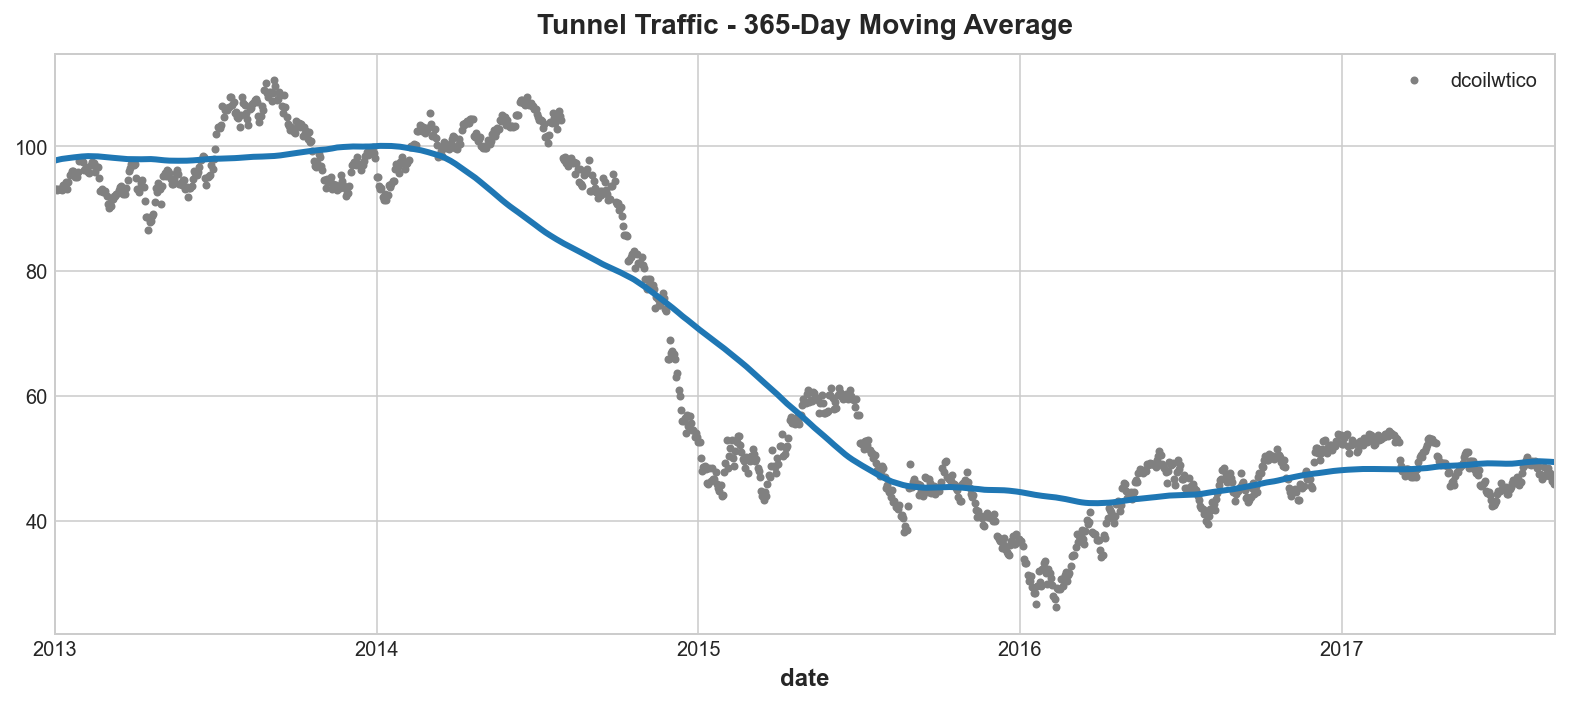

In [10]:
oil = oil.set_index('date').fillna(method = 'bfill')
moving_average = oil.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = oil.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

### Let's check if there is seasonality in the oil data!

In [13]:
'''
def grouped(df, key, freq, col):
    """ GROUP DATA WITH CERTAIN FREQUENCY """
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

def seasonal_plot(X, y, period, freq, ax=None, sample=1):
    if sample != 1:
        X=X.sample(frac=sample, replace=False, random_state=101)
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(x=X[freq], 
                      y=X[y],
                      ax=ax, 
                      hue=X[period],
                      palette=palette, 
                      legend=False)
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(name, 
                    xy=(1, y_), 
                    xytext=(6, 0), 
                    color=line.get_color(), 
                    xycoords=ax.get_yaxis_transform(), 
                    textcoords="offset points", 
                    size=14, 
                    va="center")
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(ts, fs=fs, detrend=detrend, window="boxcar", scaling='spectrum')
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(["Annual (1)", "Semiannual (2)", "Quarterly (4)", 
                        "Bimonthly (6)", "Monthly (12)", "Biweekly (26)", 
                        "Weekly (52)", "Semiweekly (104)"], rotation=30)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

def seasonality(df, key, freq, col, sample=1):
    df_grouped = grouped(df, key, freq, col)
    df_grouped['date'] = pd.to_datetime(df_grouped['date'], format = "%Y-%m-%d")
    df_grouped.index = df_grouped['date'] 
    df_grouped = df_grouped.drop(columns=['date'])
    df_grouped.index.freq = freq # manually set the frequency of the index
    
    X = df_grouped.copy()
    X.index = pd.to_datetime(X.index, format = "%Y-%m-%d") 
    X.index.freq = freq 
    # days within a week
    X["day"] = X.index.dayofweek   # the x-axis (freq)
    X["week"] = pd.Int64Index(X.index.isocalendar().week)  # the seasonal period (period)
    # days within a year
    X["dayofyear"] = X.index.dayofyear
    X["year"] = X.index.year
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 30))
    seasonal_plot(X, y='mean', period="week", freq="day", ax=ax0, sample=sample)
    seasonal_plot(X, y='mean', period="year", freq="dayofyear", ax=ax1)
    X_new = (X['mean'].copy()).dropna()
    plot_periodogram(X_new, ax=ax2)
'''

In [11]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<AxesSubplot:title={'center':'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='dcoilwtico'>

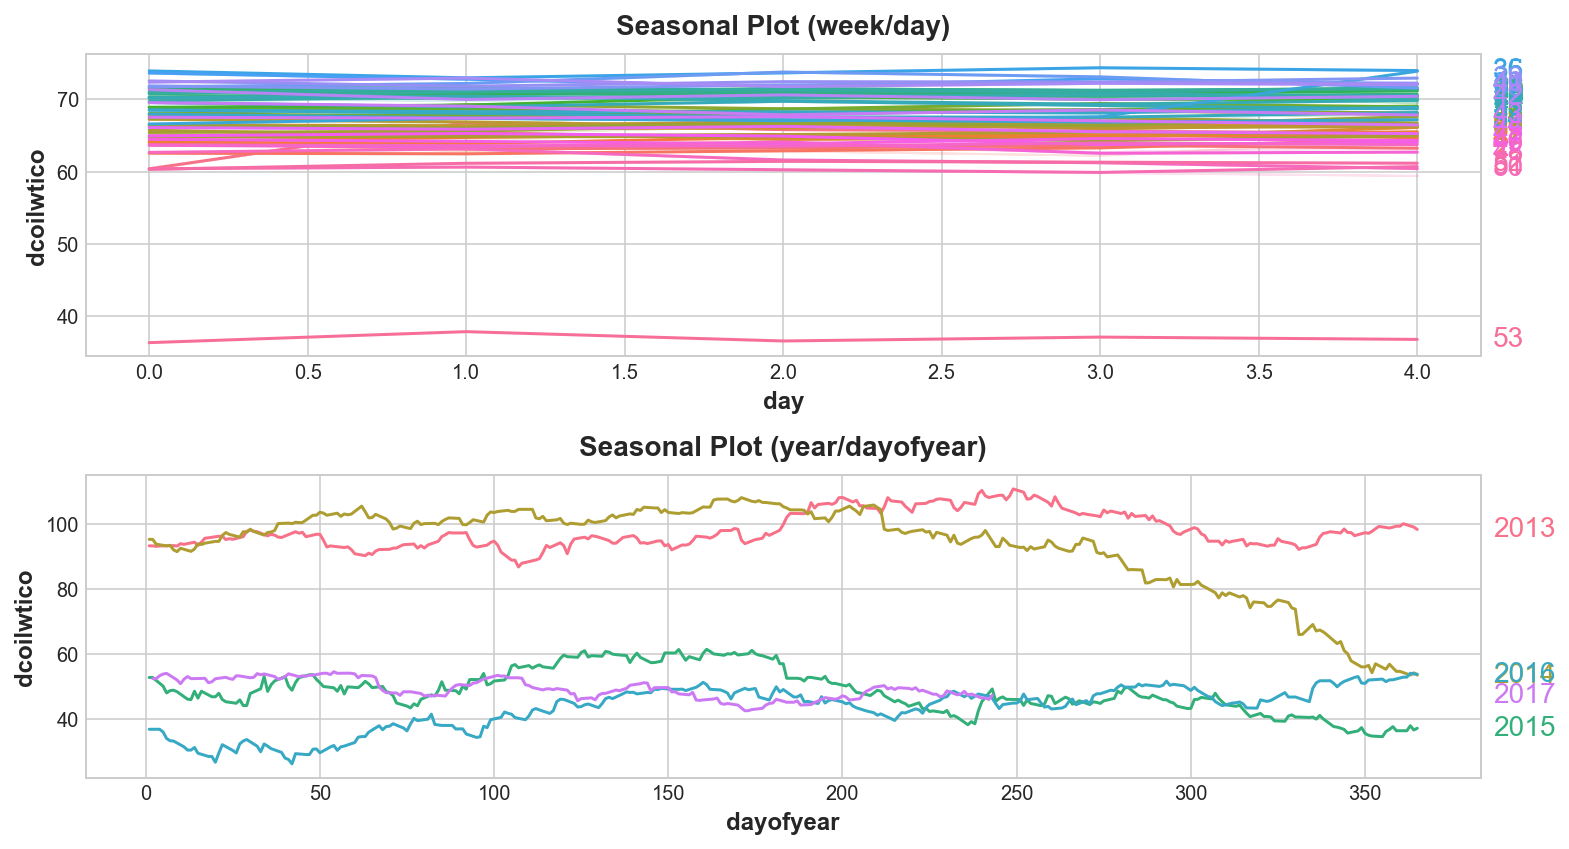

In [12]:
X = oil.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="dcoilwtico", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="dcoilwtico", period="year", freq="dayofyear", ax=ax1)

<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

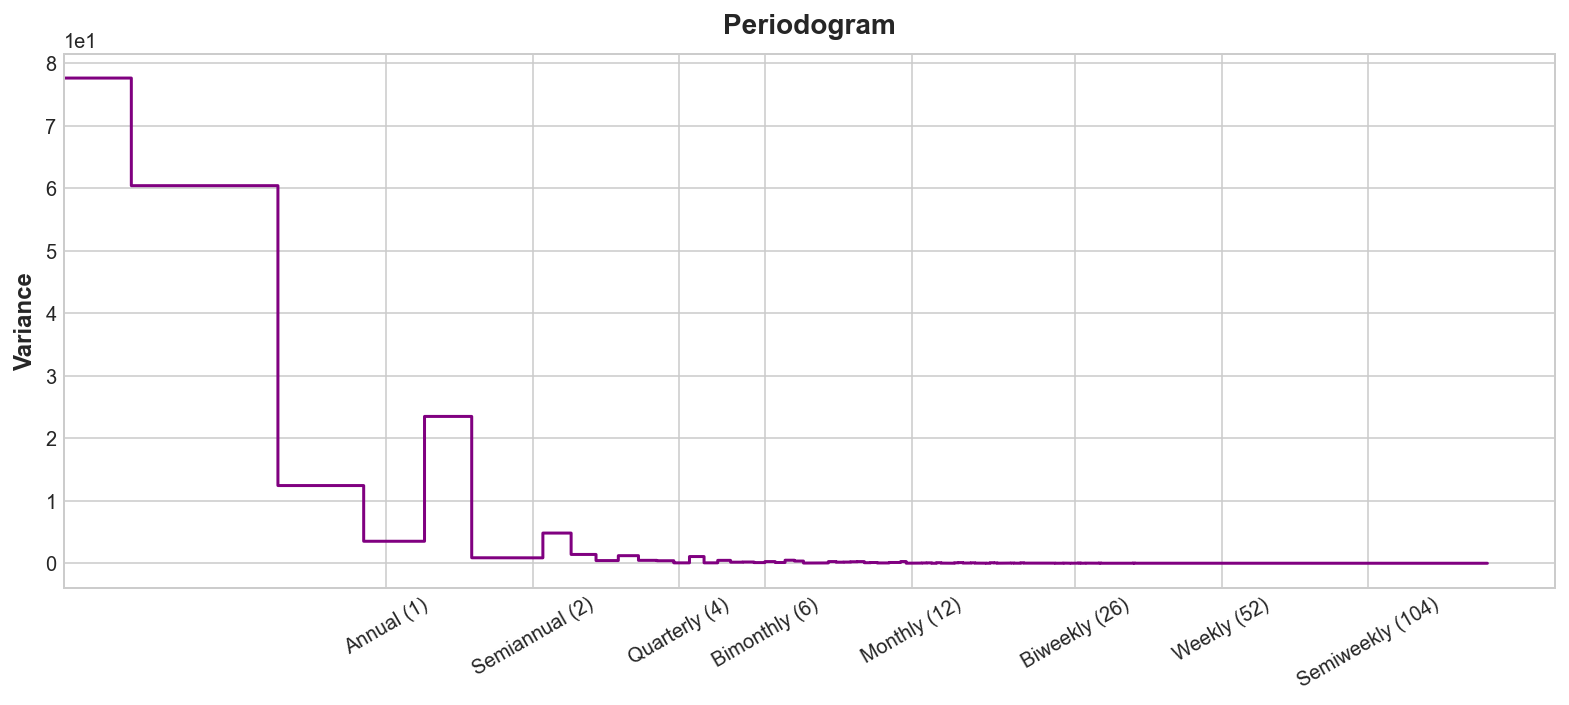

In [13]:
plot_periodogram(oil.dcoilwtico)

# Transactions data

In [14]:
# showing transactions data.
trans

date  store_nbr  transactions
0     2013-01-01         25           770
1     2013-01-02          1          2111
2     2013-01-02          2          2358
3     2013-01-02          3          3487
4     2013-01-02          4          1922
...          ...        ...           ...
83483 2017-08-15         50          2804
83484 2017-08-15         51          1573
83485 2017-08-15         52          2255
83486 2017-08-15         53           932
83487 2017-08-15         54           802

[83488 rows x 3 columns]

In [17]:
# plotting transactions data.
#aa = trans.drop('store_nbr',axis=1).groupby('date').count()
#aa

transactions
date                    
2013-01-01             1
2013-01-02            46
2013-01-03            46
2013-01-04            46
2013-01-05            46
...                  ...
2017-08-11            54
2017-08-12            54
2017-08-13            54
2017-08-14            54
2017-08-15            54

[1682 rows x 1 columns]

<AxesSubplot:title={'center':'Transaction - 365-Day Moving Average'}, xlabel='date'>

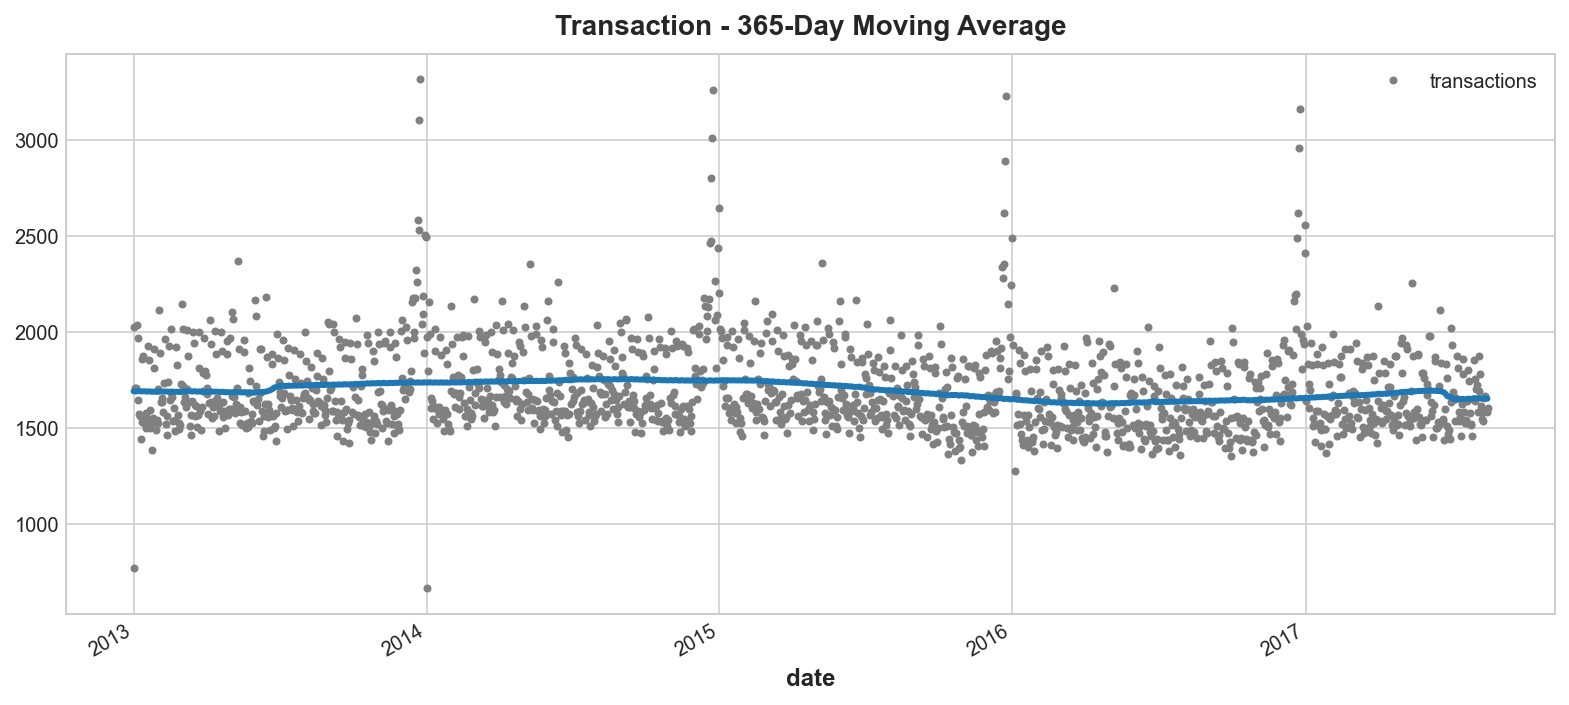

In [15]:
# plotting transactions data.
trans_date = trans.drop('store_nbr',axis=1).groupby('date').mean()
#store_nbr_trans = trans.drop('date',axis=1).groupby('store_nbr').mean()

trans_date_moving_average = trans_date.rolling(
    window=365,       
    center=True,      
    min_periods=183,  
).mean()

ax = trans_date.plot(style=".", color="0.5")
trans_date_moving_average.plot(
    ax=ax, linewidth=3, title="Transaction - 365-Day Moving Average", legend=False,
)

In [16]:
trans_date

transactions
date                    
2013-01-01        770.00
2013-01-02       2026.41
2013-01-03       1706.61
2013-01-04       1706.39
2013-01-05       2034.20
...                  ...
2017-08-11       1658.35
2017-08-12       1665.31
2017-08-13       1592.46
2017-08-14       1582.37
2017-08-15       1602.98

[1682 rows x 1 columns]

<AxesSubplot:title={'center':'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='transactions'>

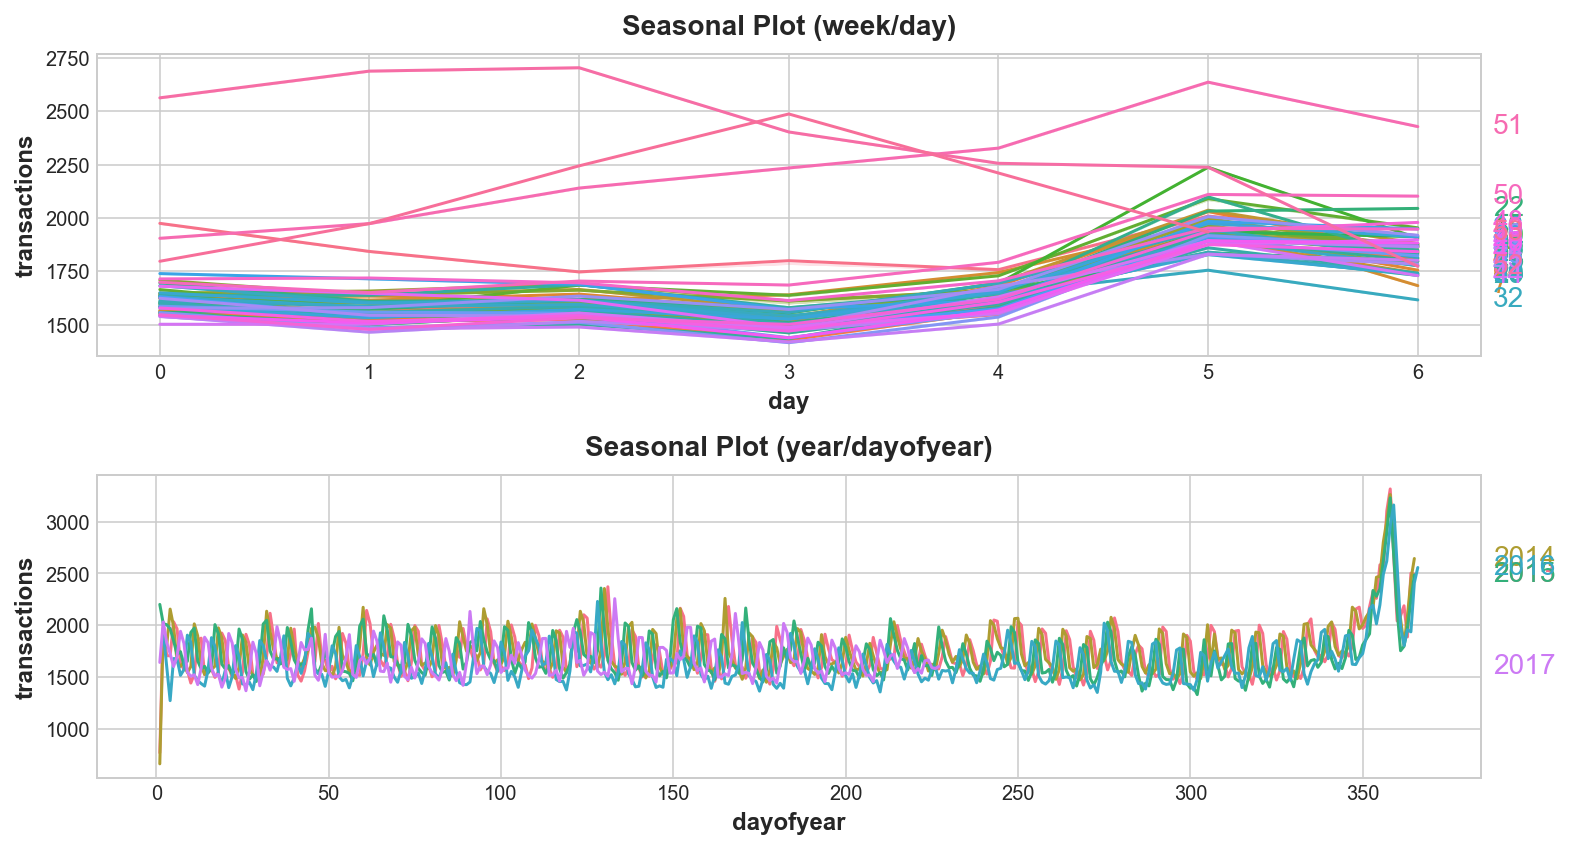

In [17]:
X = trans_date.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="transactions", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="transactions", period="year", freq="dayofyear", ax=ax1)

<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

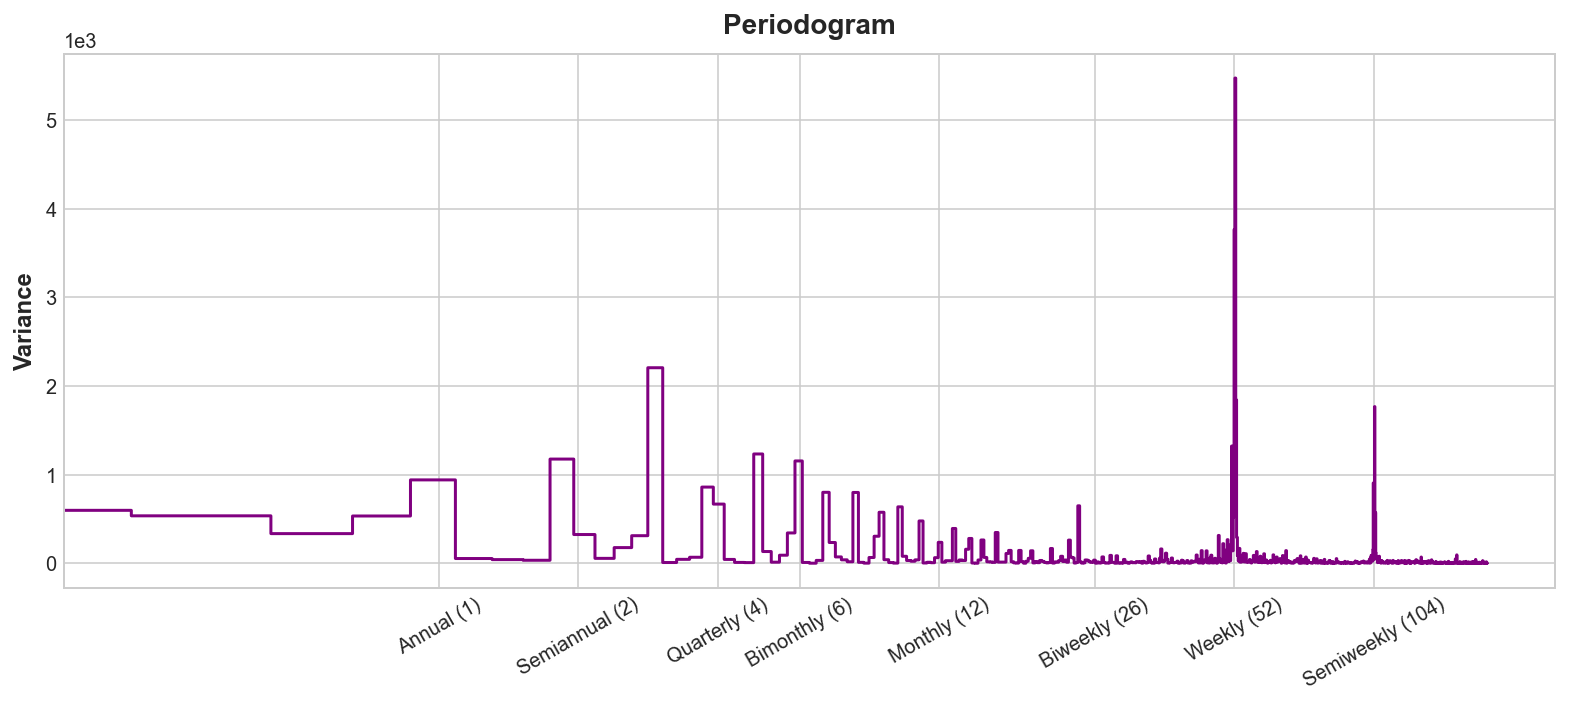

In [18]:
plot_periodogram(trans_date.transactions)

# Training Data

In [19]:
# showing train data.
train

id       date  store_nbr                      family   sales  \
0              0 2013-01-01          1                  AUTOMOTIVE    0.00   
1              1 2013-01-01          1                   BABY CARE    0.00   
2              2 2013-01-01          1                      BEAUTY    0.00   
3              3 2013-01-01          1                   BEVERAGES    0.00   
4              4 2013-01-01          1                       BOOKS    0.00   
...          ...        ...        ...                         ...     ...   
3000883  3000883 2017-08-15          9                     POULTRY  438.13   
3000884  3000884 2017-08-15          9              PREPARED FOODS  154.55   
3000885  3000885 2017-08-15          9                     PRODUCE 2419.73   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES  121.00   
3000887  3000887 2017-08-15          9                     SEAFOOD   16.00   

         onpromotion  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[3000888 rows x 6 columns]

In [20]:
train.drop('id',axis=1, inplace=True) # droping the ID column.
train["store_nbr"].describe()

count   3000888.00
mean         27.50
std          15.59
min           1.00
25%          14.00
50%          27.50
75%          41.00
max          54.00
Name: store_nbr, dtype: float64

In [21]:
train["family"].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [22]:
train.shape

(3000888, 5)

<AxesSubplot:title={'center':'sales - 365-Day Moving Average'}, xlabel='date'>

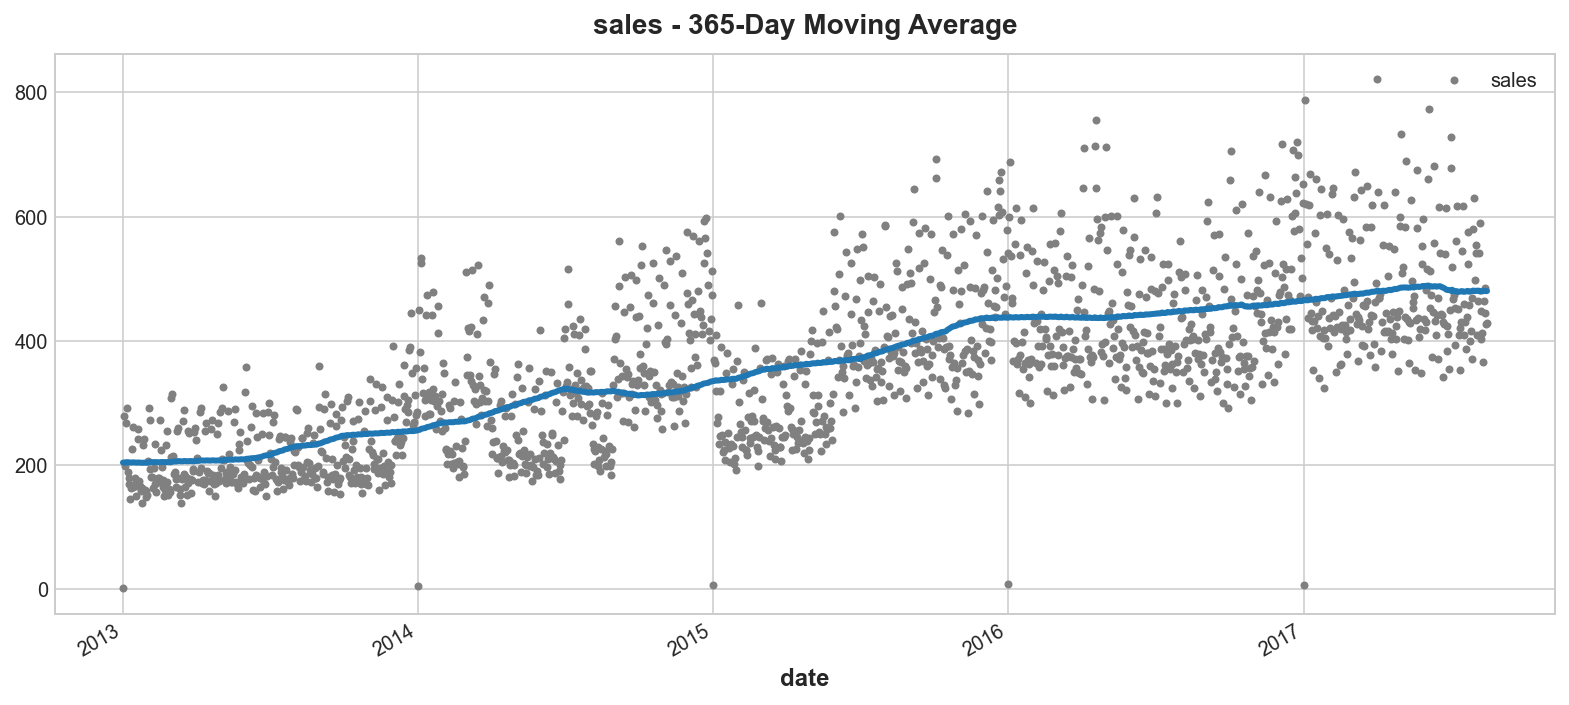

In [23]:
train_sales = train[['date','sales']].groupby('date').mean()
store_sales = train[['store_nbr','sales']].groupby('store_nbr').mean() # getting the average sales for each store.
family_sales = train[['family','sales']].groupby('family').mean() # getting the average sales for each family.
family_onpromotions = train[['family','onpromotion']].groupby('family').mean() #  getting the average promotion for each family.

# plotting.
train_sales_moving_average = train_sales.rolling(
    window=365,       
    center=True,      
    min_periods=183,  
).mean()
ax = train_sales.plot(style=".", color="0.5")
train_sales_moving_average.plot(
    ax=ax, linewidth=3, title="sales - 365-Day Moving Average", legend=False,
)

Text(0.5, 1.0, 'Store sales')

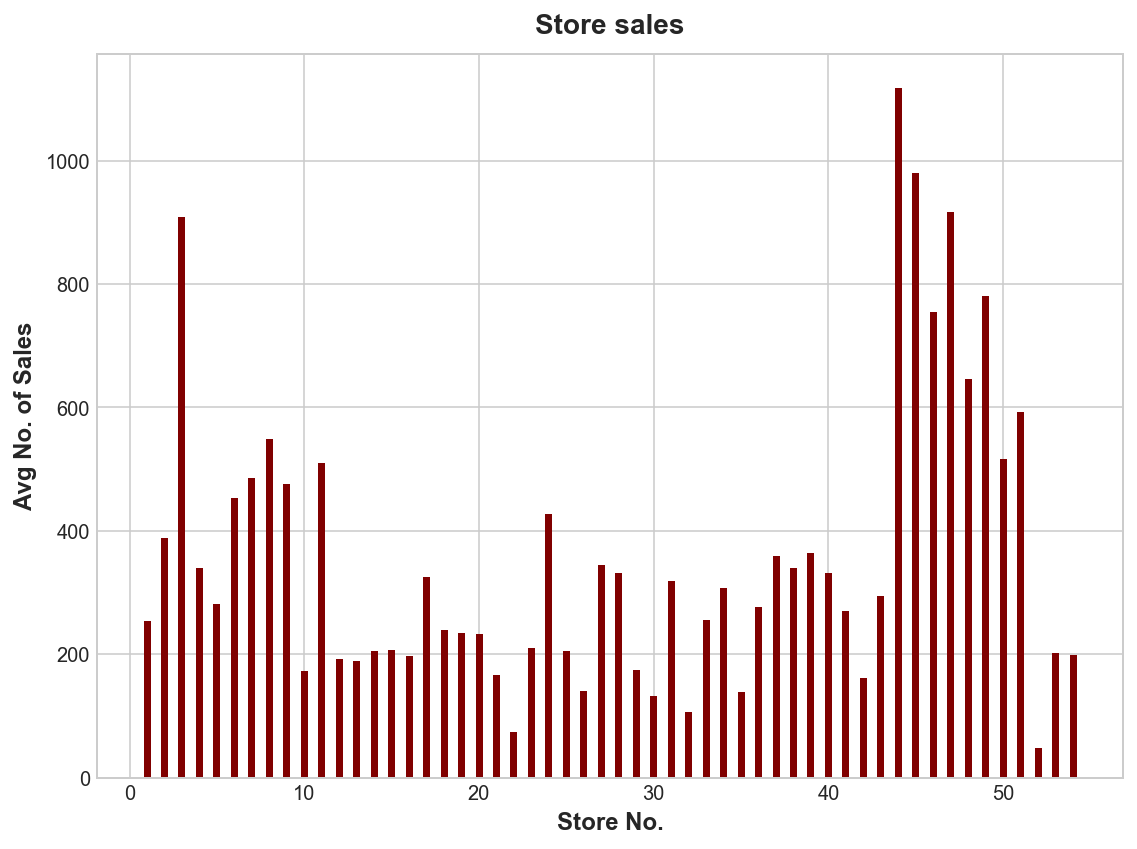

In [24]:
ind = store_sales.index
ob = store_sales.sales
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(ind, ob, color="maroon", width=.4)
ax.set_xlabel("Store No.")
ax.set_ylabel("Avg No. of Sales")
ax.set_title("Store sales")

Text(0.5, 1.0, 'Sales by Family')

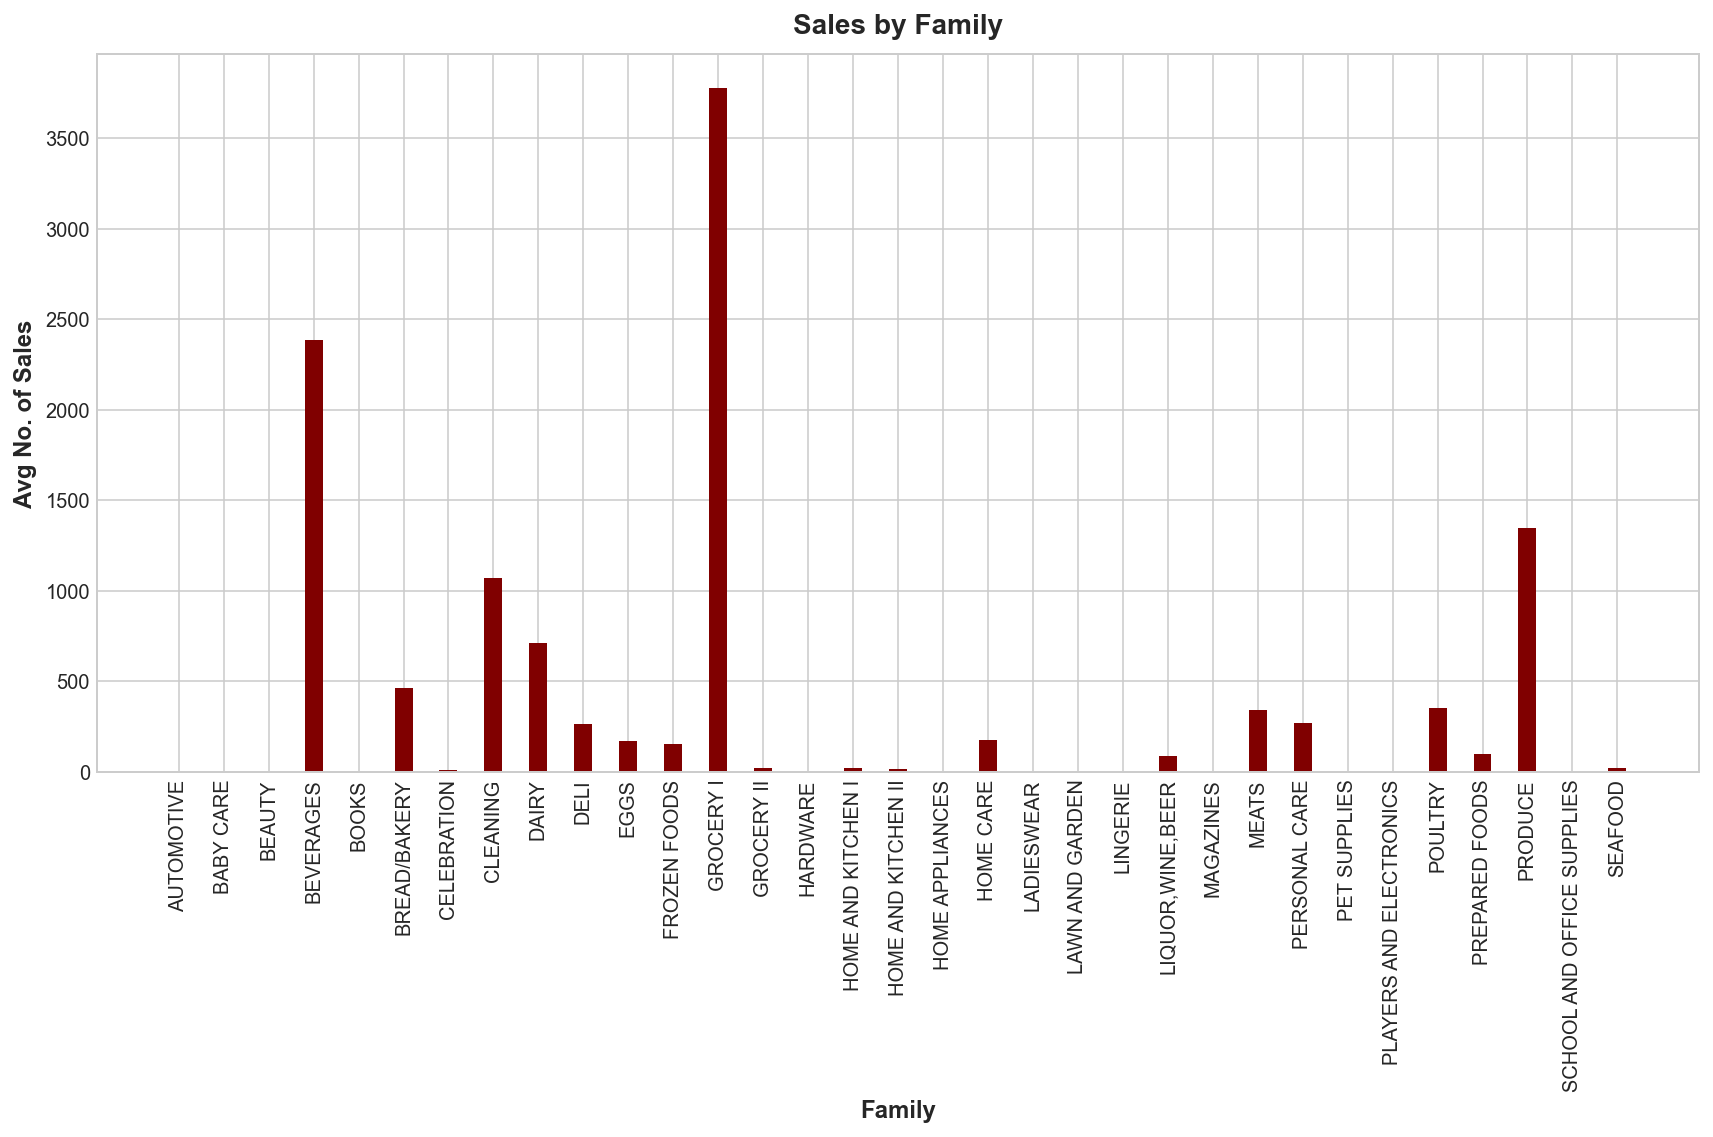

In [25]:
ind = np.arange(family_sales.shape[0])
ob = family_sales.sales
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(ind, ob, color="maroon", width=.4)
ax.set_xlabel("Family")
ax.set_ylabel("Avg No. of Sales")
ax.set_xticks(ind)
ax.set_xticklabels(family_sales.index, rotation=90)
ax.set_title("Sales by Family")

In [26]:
family_sales

sales
family                            
AUTOMOTIVE                    6.10
BABY CARE                     0.11
BEAUTY                        3.72
BEVERAGES                  2385.79
BOOKS                         0.07
BREAD/BAKERY                463.34
CELEBRATION                   8.37
CLEANING                   1072.42
DAIRY                       709.15
DELI                        265.14
EGGS                        171.42
FROZEN FOODS                154.77
GROCERY I                  3776.97
GROCERY II                   21.58
HARDWARE                      1.14
HOME AND KITCHEN I           20.47
HOME AND KITCHEN II          16.72
HOME APPLIANCES               0.46
HOME CARE                   176.20
LADIESWEAR                    7.16
LAWN AND GARDEN               6.04
LINGERIE                      7.18
LIQUOR,WINE,BEER             85.19
MAGAZINES                     2.93
MEATS                       341.85
PERSONAL CARE               270.43
PET SUPPLIES                  3.92
PLAYERS AND ELECTRONICS       6.19
POULTRY                     350.53
PREPARED FOODS               96.77
PRODUCE                    1349.35
SCHOOL AND OFFICE SUPPLIES    2.96
SEAFOOD                      22.16

In [27]:
aa=train[(train['store_nbr']==32) & (train['family']=='HOME APPLIANCES')]
aa

date  store_nbr           family  sales  onpromotion
842     2013-01-01         32  HOME APPLIANCES   0.00            0
2624    2013-01-02         32  HOME APPLIANCES   1.00            0
4406    2013-01-03         32  HOME APPLIANCES   0.00            0
6188    2013-01-04         32  HOME APPLIANCES   0.00            0
7970    2013-01-05         32  HOME APPLIANCES   1.00            0
...            ...        ...              ...    ...          ...
2992820 2017-08-11         32  HOME APPLIANCES   0.00            0
2994602 2017-08-12         32  HOME APPLIANCES   0.00            0
2996384 2017-08-13         32  HOME APPLIANCES   0.00            0
2998166 2017-08-14         32  HOME APPLIANCES   0.00            0
2999948 2017-08-15         32  HOME APPLIANCES   0.00            0

[1684 rows x 5 columns]

In [28]:
train2=train.copy()
train2=train2[train2['sales']>0]
#pd.crosstab(train2['store_nbr'], train2['family'], aggfunc='sum')
aa=train[['store_nbr','family','sales']].groupby(['store_nbr','family']).mean().reset_index()
aa[aa.family=="HOME APPLIANCES"]

store_nbr           family  sales
17            1  HOME APPLIANCES   0.34
50            2  HOME APPLIANCES   0.48
83            3  HOME APPLIANCES   1.88
116           4  HOME APPLIANCES   0.39
149           5  HOME APPLIANCES   0.55
182           6  HOME APPLIANCES   0.39
215           7  HOME APPLIANCES   0.77
248           8  HOME APPLIANCES   1.17
281           9  HOME APPLIANCES   0.39
314          10  HOME APPLIANCES   0.18
347          11  HOME APPLIANCES   0.41
380          12  HOME APPLIANCES   0.22
413          13  HOME APPLIANCES   0.15
446          14  HOME APPLIANCES   0.19
479          15  HOME APPLIANCES   0.12
512          16  HOME APPLIANCES   0.12
545          17  HOME APPLIANCES   0.17
578          18  HOME APPLIANCES   0.17
611          19  HOME APPLIANCES   0.16
644          20  HOME APPLIANCES   0.10
677          21  HOME APPLIANCES   0.14
710          22  HOME APPLIANCES   0.14
743          23  HOME APPLIANCES   0.21
776          24  HOME APPLIANCES   0.35
809          25  HOME APPLIANCES   0.13
842          26  HOME APPLIANCES   0.20
875          27  HOME APPLIANCES   0.33
908          28  HOME APPLIANCES   0.52
941          29  HOME APPLIANCES   0.14
974          30  HOME APPLIANCES   0.30
1007         31  HOME APPLIANCES   0.40
1040         32  HOME APPLIANCES   0.17
1073         33  HOME APPLIANCES   0.18
1106         34  HOME APPLIANCES   0.66
1139         35  HOME APPLIANCES   0.20
1172         36  HOME APPLIANCES   0.19
1205         37  HOME APPLIANCES   0.33
1238         38  HOME APPLIANCES   0.14
1271         39  HOME APPLIANCES   0.42
1304         40  HOME APPLIANCES   0.22
1337         41  HOME APPLIANCES   0.32
1370         42  HOME APPLIANCES   0.11
1403         43  HOME APPLIANCES   0.14
1436         44  HOME APPLIANCES   1.91
1469         45  HOME APPLIANCES   1.37
1502         46  HOME APPLIANCES   1.40
1535         47  HOME APPLIANCES   1.82
1568         48  HOME APPLIANCES   0.85
1601         49  HOME APPLIANCES   1.00
1634         50  HOME APPLIANCES   0.65
1667         51  HOME APPLIANCES   1.08
1700         52  HOME APPLIANCES   0.07
1733         53  HOME APPLIANCES   0.09
1766         54  HOME APPLIANCES   0.18

<AxesSubplot:title={'center':'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='sales'>

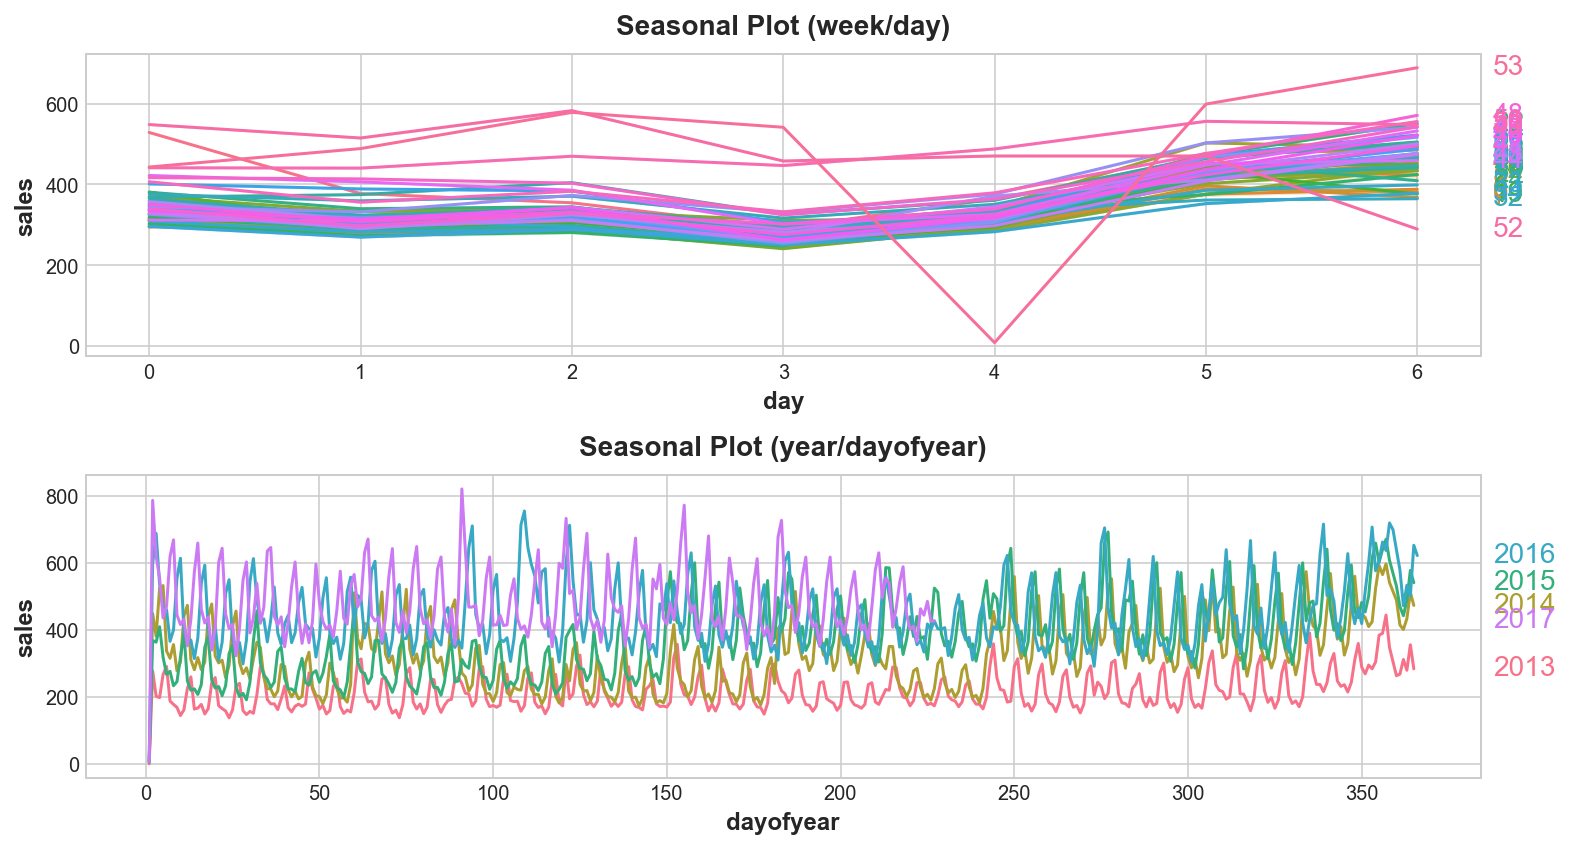

In [29]:
X = train_sales.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1)

<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

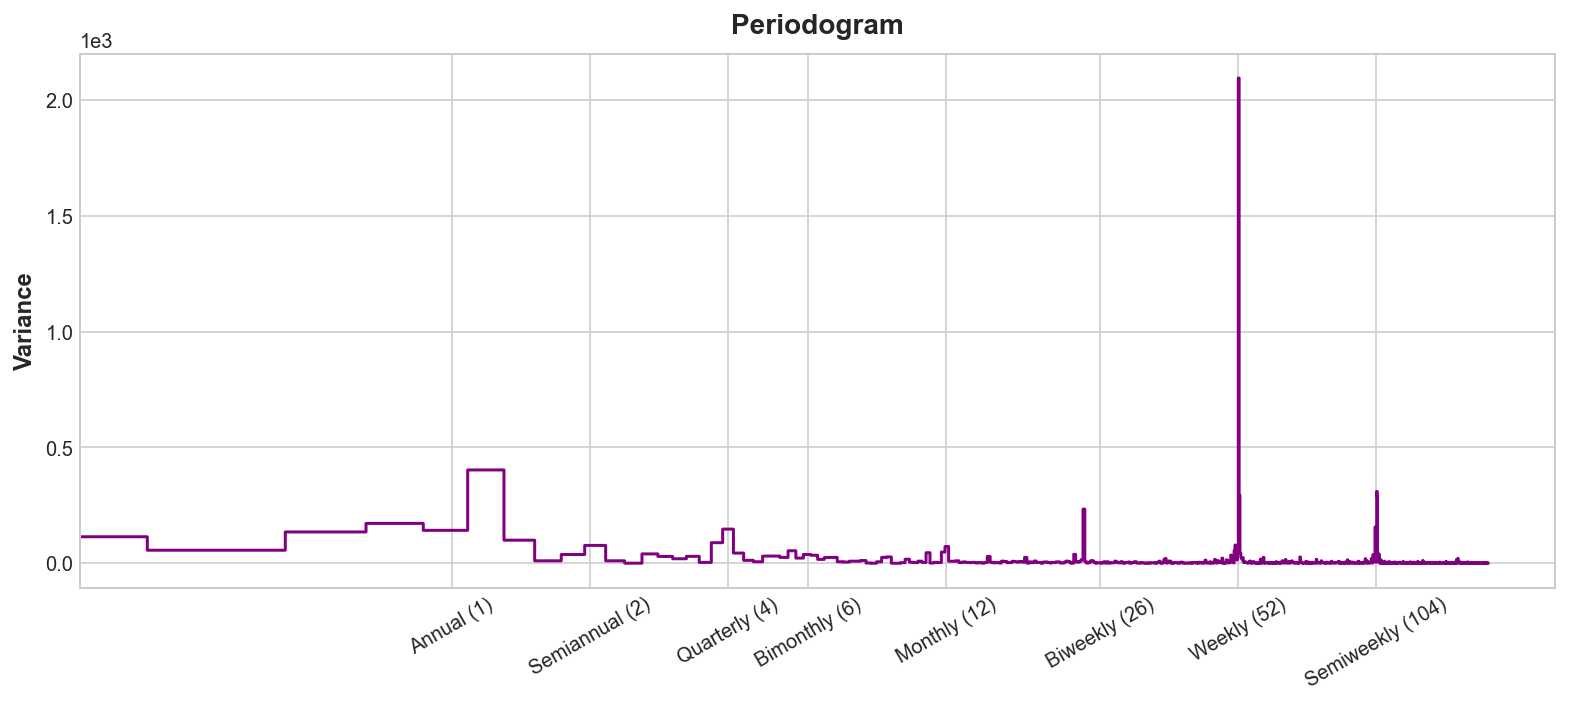

In [30]:
plot_periodogram(train_sales.sales)

## check for autocorrelation

In [31]:
from statsmodels.graphics.tsaplots import plot_pacf

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                      ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


             

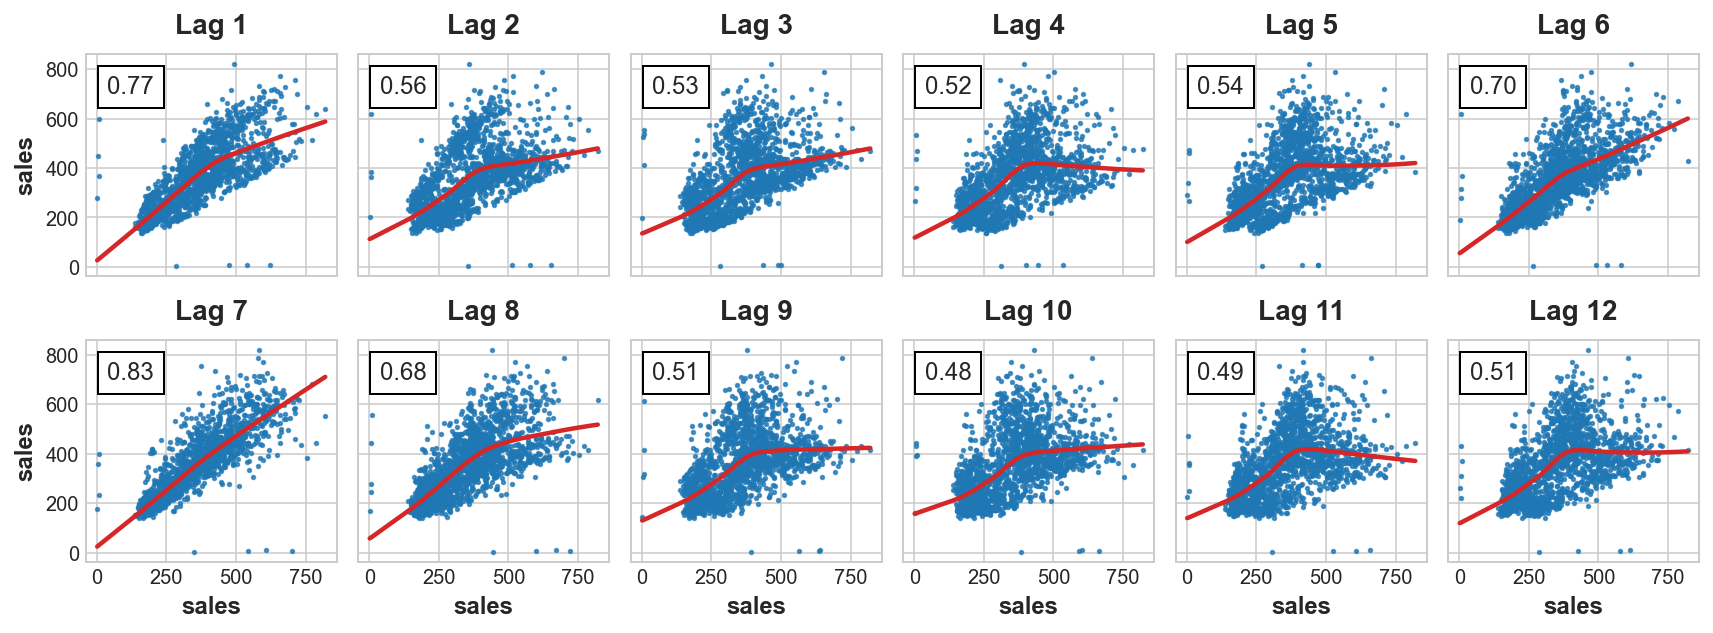

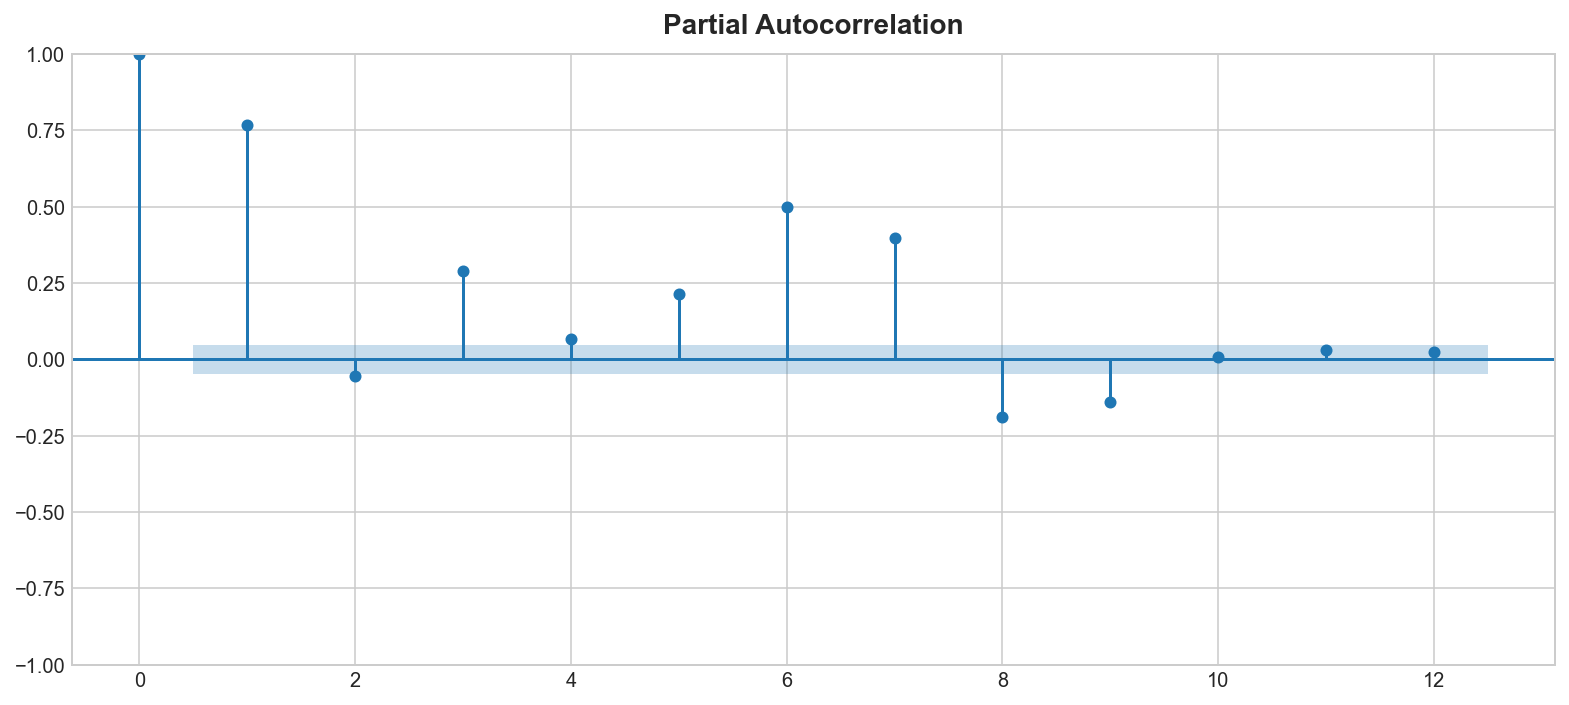

In [32]:
_ = plot_lags(train_sales.sales, lags=12, nrows=2)
_ = plot_pacf(train_sales.sales, lags=12)

In [83]:
train2[11520:11540]

date  store_nbr               family   sales  onpromotion type  \
11520 2013-01-07         32            BEVERAGES  156.00            0  NaN   
11521 2013-01-07         32                BOOKS    0.00            0  NaN   
11522 2013-01-07         32         BREAD/BAKERY   80.00            0  NaN   
11523 2013-01-07         32          CELEBRATION    0.00            0  NaN   
11524 2013-01-07         32             CLEANING  431.00            0  NaN   
11525 2013-01-07         32                DAIRY   60.00            0  NaN   
11526 2013-01-07         32                 DELI   98.00            0  NaN   
11527 2013-01-07         32                 EGGS   30.00            0  NaN   
11528 2013-01-07         32         FROZEN FOODS    3.00            0  NaN   
11529 2013-01-07         32            GROCERY I 1146.00            0  NaN   
11530 2013-01-07         32           GROCERY II    2.00            0  NaN   
11531 2013-01-07         32             HARDWARE    0.00            0  NaN   
11532 2013-01-07         32   HOME AND KITCHEN I    0.00            0  NaN   
11533 2013-01-07         32  HOME AND KITCHEN II    0.00            0  NaN   
11534 2013-01-07         32      HOME APPLIANCES    0.00            0  NaN   
11535 2013-01-07         32            HOME CARE    0.00            0  NaN   
11536 2013-01-07         32           LADIESWEAR    0.00            0  NaN   
11537 2013-01-07         32      LAWN AND GARDEN    0.00            0  NaN   
11538 2013-01-07         32             LINGERIE    2.00            0  NaN   
11539 2013-01-07         32     LIQUOR,WINE,BEER   24.00            0  NaN   

       holiday  
11520        0  
11521        0  
11522        0  
11523        0  
11524        0  
11525        0  
11526        0  
11527        0  
11528        0  
11529        0  
11530        0  
11531        0  
11532        0  
11533        0  
11534        0  
11535        0  
11536        0  
11537        0  
11538        0  
11539        0

## Add lagged vars and merge with other data

In [33]:
train2=train.copy()
# identifying holidays dates.
train2 = pd.merge(train2, holidays[['date','type']], how='left', on = 'date') # joining oil data.
train2['holiday'] =np.where(pd.isnull(train2["type"]),0,1)
train2.drop(['type'],axis=1,inplace=True) # droping unnecessary columns.
train2 = pd.merge(train2, oil, how='left', on = 'date') # joining oil data.
train2.drop_duplicates(inplace=True)
#train2['holiday'] = 0
#for date in holidays.date:
#    train2['holiday'][train2.date == date] = 1

#train_modi = pd.merge(train_modi, trans, how='left', on = ['date','store_nbr']) # joining transactions data.


In [34]:
train2.head()

date  store_nbr      family  sales  onpromotion  holiday  dcoilwtico
0 2013-01-01          1  AUTOMOTIVE   0.00            0        1       93.14
1 2013-01-01          1   BABY CARE   0.00            0        1       93.14
2 2013-01-01          1      BEAUTY   0.00            0        1       93.14
3 2013-01-01          1   BEVERAGES   0.00            0        1       93.14
4 2013-01-01          1       BOOKS   0.00            0        1       93.14

In [35]:
train2.isnull().sum()

date                0
store_nbr           0
family              0
sales               0
onpromotion         0
holiday             0
dcoilwtico     878526
dtype: int64

In [36]:
train2.fillna(method = 'bfill',inplace=True) # filling nan values.

In [48]:
train3=train2.copy()
lag=range(1,9)
for x in lag:
    lt=train2.groupby(['store_nbr','family'])['sales'].shift(x)
    lt.name='lag'+str(x)
    train3=pd.concat([train3,lt],axis=1)
train3 = train3.fillna(-1.0)

In [49]:
train3

date  store_nbr                      family   sales  \
0       2013-01-01          1                  AUTOMOTIVE    0.00   
1       2013-01-01          1                   BABY CARE    0.00   
2       2013-01-01          1                      BEAUTY    0.00   
3       2013-01-01          1                   BEVERAGES    0.00   
4       2013-01-01          1                       BOOKS    0.00   
...            ...        ...                         ...     ...   
3054343 2017-08-15          9                     POULTRY  438.13   
3054344 2017-08-15          9              PREPARED FOODS  154.55   
3054345 2017-08-15          9                     PRODUCE 2419.73   
3054346 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES  121.00   
3054347 2017-08-15          9                     SEAFOOD   16.00   

         onpromotion  holiday  dcoilwtico    lag1    lag2    lag3    lag4  \
0                  0        1       93.14     NaN     NaN     NaN     NaN   
1                  0        1       93.14     NaN     NaN     NaN     NaN   
2                  0        1       93.14     NaN     NaN     NaN     NaN   
3                  0        1       93.14     NaN     NaN     NaN     NaN   
4                  0        1       93.14     NaN     NaN     NaN     NaN   
...              ...      ...         ...     ...     ...     ...     ...   
3054343            0        1       47.57  283.43  412.46  383.39  525.22   
3054344            1        1       47.57  114.12  105.17  129.90  112.10   
3054345          148        1       47.57 1348.42 1693.61 1419.26 1453.08   
3054346            8        1       47.57  182.00  200.00  138.00  140.00   
3054347            0        1       47.57   17.00   20.00   16.86   23.83   

           lag5    lag6    lag7    lag8  
0           NaN     NaN     NaN     NaN  
1           NaN     NaN     NaN     NaN  
2           NaN     NaN     NaN     NaN  
3           NaN     NaN     NaN     NaN  
4           NaN     NaN     NaN     NaN  
...         ...     ...     ...     ...  
3054343  291.82  333.13  358.13  459.04  
3054344  111.93  123.47  112.95  119.90  
3054345 1036.44 1310.45 2299.72 1675.09  
3054346  148.00   83.00  170.00  146.00  
3054347   14.35   17.60   15.68   23.63  

[3000888 rows x 15 columns]

In [100]:
#grouped_df=train2.groupby(['store_nbr','family'])
#for key, item in grouped_df:
#    print(grouped_df.get_group(key), "\n\n")

              date  store_nbr      family  sales  onpromotion  holiday  \
0       2013-01-01          1  AUTOMOTIVE   0.00            0        1   
1782    2013-01-02          1  AUTOMOTIVE   2.00            0        0   
3564    2013-01-03          1  AUTOMOTIVE   3.00            0        0   
5346    2013-01-04          1  AUTOMOTIVE   3.00            0        0   
7128    2013-01-05          1  AUTOMOTIVE   5.00            0        1   
...            ...        ...         ...    ...          ...      ...   
3045438 2017-08-11          1  AUTOMOTIVE   1.00            0        1   
3047220 2017-08-12          1  AUTOMOTIVE   6.00            0        0   
3049002 2017-08-13          1  AUTOMOTIVE   1.00            0        0   
3050784 2017-08-14          1  AUTOMOTIVE   1.00            0        0   
3052566 2017-08-15          1  AUTOMOTIVE   4.00            0        1   

         dcoilwtico  
0             93.14  
1782          93.14  
3564          92.97  
5346          93.12  
7

[1714 rows x 7 columns] 


              date  store_nbr           family  sales  onpromotion  holiday  \
380     2013-01-01          2  HOME APPLIANCES   0.00            0        1   
2162    2013-01-02          2  HOME APPLIANCES   0.00            0        0   
3944    2013-01-03          2  HOME APPLIANCES   0.00            0        0   
5726    2013-01-04          2  HOME APPLIANCES   0.00            0        0   
7508    2013-01-05          2  HOME APPLIANCES   0.00            0        1   
...            ...        ...              ...    ...          ...      ...   
3045818 2017-08-11          2  HOME APPLIANCES   0.00            0        1   
3047600 2017-08-12          2  HOME APPLIANCES   0.00            0        0   
3049382 2017-08-13          2  HOME APPLIANCES   0.00            0        0   
3051164 2017-08-14          2  HOME APPLIANCES   0.00            0        0   
3052946 2017-08-15          2  HOME APPLIANCES   0.00            0        1   

         dcoilwtico  
38

              date  store_nbr     family  sales  onpromotion  holiday  \
749     2013-01-01          3  MAGAZINES   0.00            0        1   
2531    2013-01-02          3  MAGAZINES   0.00            0        0   
4313    2013-01-03          3  MAGAZINES   0.00            0        0   
6095    2013-01-04          3  MAGAZINES   0.00            0        0   
7877    2013-01-05          3  MAGAZINES   0.00            0        1   
...            ...        ...        ...    ...          ...      ...   
3046187 2017-08-11          3  MAGAZINES  35.00            0        1   
3047969 2017-08-12          3  MAGAZINES  29.00            0        0   
3049751 2017-08-13          3  MAGAZINES  33.00            0        0   
3051533 2017-08-14          3  MAGAZINES  20.00            0        0   
3053315 2017-08-15          3  MAGAZINES  37.00            0        1   

         dcoilwtico  
749           93.14  
2531          93.14  
4313          92.97  
6095          93.12  
7877         

[1714 rows x 7 columns] 


              date  store_nbr       family  sales  onpromotion  holiday  \
1458    2013-01-01          5  CELEBRATION   0.00            0        1   
3240    2013-01-02          5  CELEBRATION   0.00            0        0   
5022    2013-01-03          5  CELEBRATION   0.00            0        0   
6804    2013-01-04          5  CELEBRATION   0.00            0        0   
8586    2013-01-05          5  CELEBRATION   0.00            0        1   
...            ...        ...          ...    ...          ...      ...   
3046896 2017-08-11          5  CELEBRATION  39.00            0        1   
3048678 2017-08-12          5  CELEBRATION  23.00            0        0   
3050460 2017-08-13          5  CELEBRATION  20.00            0        0   
3052242 2017-08-14          5  CELEBRATION  28.00            0        0   
3054024 2017-08-15          5  CELEBRATION  28.00            0        1   

         dcoilwtico  
1458          93.14  
3240          93.14  
5022  

              date  store_nbr    family  sales  onpromotion  holiday  \
1671    2013-01-01          6  LINGERIE   0.00            0        1   
3453    2013-01-02          6  LINGERIE   2.00            0        0   
5235    2013-01-03          6  LINGERIE   6.00            0        0   
7017    2013-01-04          6  LINGERIE   5.00            0        0   
8799    2013-01-05          6  LINGERIE   9.00            0        1   
...            ...        ...       ...    ...          ...      ...   
3047109 2017-08-11          6  LINGERIE  20.00            6        1   
3048891 2017-08-12          6  LINGERIE  11.00            4        0   
3050673 2017-08-13          6  LINGERIE   5.00            3        0   
3052455 2017-08-14          6  LINGERIE   8.00            3        0   
3054237 2017-08-15          6  LINGERIE   6.00            3        1   

         dcoilwtico  
1671          93.14  
3453          93.14  
5235          92.97  
7017          93.12  
8799          93.20  
...

[1714 rows x 7 columns] 


              date  store_nbr     family  sales  onpromotion  holiday  \
1717    2013-01-01          8  BABY CARE   0.00            0        1   
3499    2013-01-02          8  BABY CARE   0.00            0        0   
5281    2013-01-03          8  BABY CARE   0.00            0        0   
7063    2013-01-04          8  BABY CARE   0.00            0        0   
8845    2013-01-05          8  BABY CARE   0.00            0        1   
...            ...        ...        ...    ...          ...      ...   
3047155 2017-08-11          8  BABY CARE   1.00            0        1   
3048937 2017-08-12          8  BABY CARE   0.00            0        0   
3050719 2017-08-13          8  BABY CARE   1.00            0        0   
3052501 2017-08-14          8  BABY CARE   3.00            0        0   
3054283 2017-08-15          8  BABY CARE   1.00            0        1   

         dcoilwtico  
1717          93.14  
3499          93.14  
5281          92.97  
7063    

[1714 rows x 7 columns] 


              date  store_nbr               family  sales  onpromotion  \
1765    2013-01-01          9  HOME AND KITCHEN II   0.00            0   
3547    2013-01-02          9  HOME AND KITCHEN II   0.00            0   
5329    2013-01-03          9  HOME AND KITCHEN II   0.00            0   
7111    2013-01-04          9  HOME AND KITCHEN II   0.00            0   
8893    2013-01-05          9  HOME AND KITCHEN II   0.00            0   
...            ...        ...                  ...    ...          ...   
3047203 2017-08-11          9  HOME AND KITCHEN II  35.00            2   
3048985 2017-08-12          9  HOME AND KITCHEN II  59.00            1   
3050767 2017-08-13          9  HOME AND KITCHEN II  64.00            1   
3052549 2017-08-14          9  HOME AND KITCHEN II  43.00            1   
3054331 2017-08-15          9  HOME AND KITCHEN II  61.00            2   

         holiday  dcoilwtico  
1765           1       93.14  
3547           0      

              date  store_nbr   family  sales  onpromotion  holiday  \
61      2013-01-01         10  POULTRY   0.00            0        1   
1843    2013-01-02         10  POULTRY 146.78            0        0   
3625    2013-01-03         10  POULTRY 148.32            0        0   
5407    2013-01-04         10  POULTRY 111.16            0        0   
7189    2013-01-05         10  POULTRY 135.60            0        1   
...            ...        ...      ...    ...          ...      ...   
3045499 2017-08-11         10  POULTRY 169.42           16        1   
3047281 2017-08-12         10  POULTRY 147.00            0        0   
3049063 2017-08-13         10  POULTRY 201.74            0        0   
3050845 2017-08-14         10  POULTRY 133.71            0        0   
3052627 2017-08-15         10  POULTRY 102.08            0        1   

         dcoilwtico  
61            93.14  
1843          93.14  
3625          92.97  
5407          93.12  
7189          93.20  
...            

[1714 rows x 7 columns] 


              date  store_nbr family  sales  onpromotion  holiday  dcoilwtico
109     2013-01-01         12   EGGS   0.00            0        1       93.14
1891    2013-01-02         12   EGGS  75.00            0        0       93.14
3673    2013-01-03         12   EGGS  41.00            0        0       92.97
5455    2013-01-04         12   EGGS  32.00            0        0       93.12
7237    2013-01-05         12   EGGS  39.00            0        1       93.20
...            ...        ...    ...    ...          ...      ...         ...
3045547 2017-08-11         12   EGGS  65.00            1        1       48.81
3047329 2017-08-12         12   EGGS  43.00            1        0       47.59
3049111 2017-08-13         12   EGGS  45.00            1        0       47.59
3050893 2017-08-14         12   EGGS 117.00           10        0       47.59
3052675 2017-08-15         12   EGGS  15.00            1        1       47.57

[1714 rows x 7 columns] 


         

[1714 rows x 7 columns] 


              date  store_nbr         family  sales  onpromotion  holiday  \
157     2013-01-01         13  PERSONAL CARE   0.00            0        1   
1939    2013-01-02         13  PERSONAL CARE 241.00            0        0   
3721    2013-01-03         13  PERSONAL CARE 210.00            0        0   
5503    2013-01-04         13  PERSONAL CARE 164.00            0        0   
7285    2013-01-05         13  PERSONAL CARE 239.00            0        1   
...            ...        ...            ...    ...          ...      ...   
3045595 2017-08-11         13  PERSONAL CARE 135.00            4        1   
3047377 2017-08-12         13  PERSONAL CARE 211.00            7        0   
3049159 2017-08-13         13  PERSONAL CARE 235.00            7        0   
3050941 2017-08-14         13  PERSONAL CARE 174.00            6        0   
3052723 2017-08-15         13  PERSONAL CARE 177.00            5        1   

         dcoilwtico  
157           93.14  
1939

[1714 rows x 7 columns] 


              date  store_nbr       family  sales  onpromotion  holiday  \
204     2013-01-01         15  CELEBRATION   0.00            0        1   
1986    2013-01-02         15  CELEBRATION   0.00            0        0   
3768    2013-01-03         15  CELEBRATION   0.00            0        0   
5550    2013-01-04         15  CELEBRATION   0.00            0        0   
7332    2013-01-05         15  CELEBRATION   0.00            0        1   
...            ...        ...          ...    ...          ...      ...   
3045642 2017-08-11         15  CELEBRATION   0.00            0        1   
3047424 2017-08-12         15  CELEBRATION   5.00            0        0   
3049206 2017-08-13         15  CELEBRATION   4.00            0        0   
3050988 2017-08-14         15  CELEBRATION  20.00            0        0   
3052770 2017-08-15         15  CELEBRATION   2.00            0        1   

         dcoilwtico  
204           93.14  
1986          93.14  
3768  

[1714 rows x 7 columns] 


              date  store_nbr      family  sales  onpromotion  holiday  \
250     2013-01-01         16  LADIESWEAR   0.00            0        1   
2032    2013-01-02         16  LADIESWEAR   0.00            0        0   
3814    2013-01-03         16  LADIESWEAR   0.00            0        0   
5596    2013-01-04         16  LADIESWEAR   0.00            0        0   
7378    2013-01-05         16  LADIESWEAR   0.00            0        1   
...            ...        ...         ...    ...          ...      ...   
3045688 2017-08-11         16  LADIESWEAR   0.00            0        1   
3047470 2017-08-12         16  LADIESWEAR   0.00            0        0   
3049252 2017-08-13         16  LADIESWEAR   0.00            0        0   
3051034 2017-08-14         16  LADIESWEAR   0.00            0        0   
3052816 2017-08-15         16  LADIESWEAR   0.00            0        1   

         dcoilwtico  
250           93.14  
2032          93.14  
3814          92.9

[1714 rows x 7 columns] 


              date  store_nbr  family  sales  onpromotion  holiday  dcoilwtico
299     2013-01-01         18  BEAUTY   0.00            0        1       93.14
2081    2013-01-02         18  BEAUTY   2.00            0        0       93.14
3863    2013-01-03         18  BEAUTY   0.00            0        0       92.97
5645    2013-01-04         18  BEAUTY   2.00            0        0       93.12
7427    2013-01-05         18  BEAUTY   3.00            0        1       93.20
...            ...        ...     ...    ...          ...      ...         ...
3045737 2017-08-11         18  BEAUTY   1.00            0        1       48.81
3047519 2017-08-12         18  BEAUTY   6.00            2        0       47.59
3049301 2017-08-13         18  BEAUTY   3.00            2        0       47.59
3051083 2017-08-14         18  BEAUTY   2.00            1        0       47.59
3052865 2017-08-15         18  BEAUTY   7.00            1        1       47.57

[1714 rows x 7 columns] 

[1714 rows x 7 columns] 


              date  store_nbr        family  sales  onpromotion  holiday  \
341     2013-01-01         19  FROZEN FOODS   0.00            0        1   
2123    2013-01-02         19  FROZEN FOODS  13.00            0        0   
3905    2013-01-03         19  FROZEN FOODS  17.00            0        0   
5687    2013-01-04         19  FROZEN FOODS  11.00            0        0   
7469    2013-01-05         19  FROZEN FOODS  22.00            0        1   
...            ...        ...           ...    ...          ...      ...   
3045779 2017-08-11         19  FROZEN FOODS  57.00            1        1   
3047561 2017-08-12         19  FROZEN FOODS  60.00           14        0   
3049343 2017-08-13         19  FROZEN FOODS  24.89            0        0   
3051125 2017-08-14         19  FROZEN FOODS  39.00            1        0   
3052907 2017-08-15         19  FROZEN FOODS  33.00            0        1   

         dcoilwtico  
341           93.14  
2123          93

              date  store_nbr                   family  sales  onpromotion  \
423     2013-01-01         20  PLAYERS AND ELECTRONICS   0.00            0   
2205    2013-01-02         20  PLAYERS AND ELECTRONICS   0.00            0   
3987    2013-01-03         20  PLAYERS AND ELECTRONICS   0.00            0   
5769    2013-01-04         20  PLAYERS AND ELECTRONICS   0.00            0   
7551    2013-01-05         20  PLAYERS AND ELECTRONICS   0.00            0   
...            ...        ...                      ...    ...          ...   
3045861 2017-08-11         20  PLAYERS AND ELECTRONICS  11.00            0   
3047643 2017-08-12         20  PLAYERS AND ELECTRONICS   6.00            0   
3049425 2017-08-13         20  PLAYERS AND ELECTRONICS  16.00            0   
3051207 2017-08-14         20  PLAYERS AND ELECTRONICS   6.00            0   
3052989 2017-08-15         20  PLAYERS AND ELECTRONICS   8.00            0   

         holiday  dcoilwtico  
423            1       93.14  
2

              date  store_nbr        family  sales  onpromotion  holiday  \
473     2013-01-01         22  FROZEN FOODS   0.00            0        1   
2255    2013-01-02         22  FROZEN FOODS   0.00            0        0   
4037    2013-01-03         22  FROZEN FOODS   0.00            0        0   
5819    2013-01-04         22  FROZEN FOODS   0.00            0        0   
7601    2013-01-05         22  FROZEN FOODS   0.00            0        1   
...            ...        ...           ...    ...          ...      ...   
3045911 2017-08-11         22  FROZEN FOODS  63.00            1        1   
3047693 2017-08-12         22  FROZEN FOODS 175.80           17        0   
3049475 2017-08-13         22  FROZEN FOODS  50.00            1        0   
3051257 2017-08-14         22  FROZEN FOODS  37.00            1        0   
3053039 2017-08-15         22  FROZEN FOODS  55.00            0        1   

         dcoilwtico  
473           93.14  
2255          93.14  
4037          92.97  

[1714 rows x 7 columns] 


              date  store_nbr family   sales  onpromotion  holiday  dcoilwtico
519     2013-01-01         23  MEATS    0.00            0        1       93.14
2301    2013-01-02         23  MEATS  517.36            0        0       93.14
4083    2013-01-03         23  MEATS  383.16            0        0       92.97
5865    2013-01-04         23  MEATS  493.01            0        0       93.12
7647    2013-01-05         23  MEATS  672.25            0        1       93.20
...            ...        ...    ...     ...          ...      ...         ...
3045957 2017-08-11         23  MEATS  434.71           46        1       48.81
3047739 2017-08-12         23  MEATS  216.89            0        0       47.59
3049521 2017-08-13         23  MEATS 1065.35            0        0       47.59
3051303 2017-08-14         23  MEATS  355.26            0        0       47.59
3053085 2017-08-15         23  MEATS  918.84            0        1       47.57

[1714 rows x 7 columns] 

              date  store_nbr   family  sales  onpromotion  holiday  \
556     2013-01-01         24  POULTRY   0.00            0        1   
2338    2013-01-02         24  POULTRY 169.44            0        0   
4120    2013-01-03         24  POULTRY 313.25            0        0   
5902    2013-01-04         24  POULTRY 403.88            0        0   
7684    2013-01-05         24  POULTRY 368.68            0        1   
...            ...        ...      ...    ...          ...      ...   
3045994 2017-08-11         24  POULTRY 605.14           38        1   
3047776 2017-08-12         24  POULTRY 467.26            0        0   
3049558 2017-08-13         24  POULTRY 399.21            0        0   
3051340 2017-08-14         24  POULTRY 540.38            0        0   
3053122 2017-08-15         24  POULTRY 513.65            0        1   

         dcoilwtico  
556           93.14  
2338          93.14  
4120          92.97  
5902          93.12  
7684          93.20  
...            

[1714 rows x 7 columns] 


              date  store_nbr        family  sales  onpromotion  holiday  \
605     2013-01-01         26  FROZEN FOODS   0.00            0        1   
2387    2013-01-02         26  FROZEN FOODS  51.58            0        0   
4169    2013-01-03         26  FROZEN FOODS  32.82            0        0   
5951    2013-01-04         26  FROZEN FOODS  33.59            0        0   
7733    2013-01-05         26  FROZEN FOODS  17.00            0        1   
...            ...        ...           ...    ...          ...      ...   
3046043 2017-08-11         26  FROZEN FOODS  76.03            0        1   
3047825 2017-08-12         26  FROZEN FOODS  24.00            1        0   
3049607 2017-08-13         26  FROZEN FOODS  41.00            1        0   
3051389 2017-08-14         26  FROZEN FOODS  33.80            1        0   
3053171 2017-08-15         26  FROZEN FOODS  25.00            0        1   

         dcoilwtico  
605           93.14  
2387          93

[1714 rows x 7 columns] 


              date  store_nbr   family  sales  onpromotion  holiday  \
655     2013-01-01         27  POULTRY   0.00            0        1   
2437    2013-01-02         27  POULTRY 279.86            0        0   
4219    2013-01-03         27  POULTRY 134.27            0        0   
6001    2013-01-04         27  POULTRY 100.80            0        0   
7783    2013-01-05         27  POULTRY 220.37            0        1   
...            ...        ...      ...    ...          ...      ...   
3046093 2017-08-11         27  POULTRY 506.22           38        1   
3047875 2017-08-12         27  POULTRY 367.86            0        0   
3049657 2017-08-13         27  POULTRY 487.43            0        0   
3051439 2017-08-14         27  POULTRY 440.13            0        0   
3053221 2017-08-15         27  POULTRY 382.93            0        1   

         dcoilwtico  
655           93.14  
2437          93.14  
4219          92.97  
6001          93.12  
7783      

[1714 rows x 7 columns] 


              date  store_nbr     family   sales  onpromotion  holiday  \
705     2013-01-01         29  GROCERY I    0.00            0        1   
2487    2013-01-02         29  GROCERY I    0.00            0        0   
4269    2013-01-03         29  GROCERY I    0.00            0        0   
6051    2013-01-04         29  GROCERY I    0.00            0        0   
7833    2013-01-05         29  GROCERY I    0.00            0        1   
...            ...        ...        ...     ...          ...      ...   
3046143 2017-08-11         29  GROCERY I 3915.59           70        1   
3047925 2017-08-12         29  GROCERY I 3924.67           66        0   
3049707 2017-08-13         29  GROCERY I 5512.04           66        0   
3051489 2017-08-14         29  GROCERY I 3572.55           61        0   
3053271 2017-08-15         29  GROCERY I 4566.33           64        1   

         dcoilwtico  
705           93.14  
2487          93.14  
4269          92.9

              date  store_nbr        family  sales  onpromotion  holiday  \
785     2013-01-01         30  PET SUPPLIES   0.00            0        1   
2567    2013-01-02         30  PET SUPPLIES   0.00            0        0   
4349    2013-01-03         30  PET SUPPLIES   0.00            0        0   
6131    2013-01-04         30  PET SUPPLIES   0.00            0        0   
7913    2013-01-05         30  PET SUPPLIES   0.00            0        1   
...            ...        ...           ...    ...          ...      ...   
3046223 2017-08-11         30  PET SUPPLIES   3.00            0        1   
3048005 2017-08-12         30  PET SUPPLIES   3.00            0        0   
3049787 2017-08-13         30  PET SUPPLIES   2.00            0        0   
3051569 2017-08-14         30  PET SUPPLIES   2.00            0        0   
3053351 2017-08-15         30  PET SUPPLIES   2.00            0        1   

         dcoilwtico  
785           93.14  
2567          93.14  
4349          92.97  

[1714 rows x 7 columns] 


              date  store_nbr    family  sales  onpromotion  holiday  \
832     2013-01-01         32  CLEANING   0.00            0        1   
2614    2013-01-02         32  CLEANING 463.00            0        0   
4396    2013-01-03         32  CLEANING 451.00            0        0   
6178    2013-01-04         32  CLEANING 480.00            0        0   
7960    2013-01-05         32  CLEANING 465.00            0        1   
...            ...        ...       ...    ...          ...      ...   
3046270 2017-08-11         32  CLEANING 342.00           21        1   
3048052 2017-08-12         32  CLEANING 865.00           21        0   
3049834 2017-08-13         32  CLEANING 433.00           14        0   
3051616 2017-08-14         32  CLEANING 475.00           17        0   
3053398 2017-08-15         32  CLEANING 789.00           17        1   

         dcoilwtico  
832           93.14  
2614          93.14  
4396          92.97  
6178          93.12 

[1714 rows x 7 columns] 


              date  store_nbr     family  sales  onpromotion  holiday  \
881     2013-01-01         33  MAGAZINES   0.00            0        1   
2663    2013-01-02         33  MAGAZINES   0.00            0        0   
4445    2013-01-03         33  MAGAZINES   0.00            0        0   
6227    2013-01-04         33  MAGAZINES   0.00            0        0   
8009    2013-01-05         33  MAGAZINES   0.00            0        1   
...            ...        ...        ...    ...          ...      ...   
3046319 2017-08-11         33  MAGAZINES   1.00            0        1   
3048101 2017-08-12         33  MAGAZINES   2.00            0        0   
3049883 2017-08-13         33  MAGAZINES   2.00            0        0   
3051665 2017-08-14         33  MAGAZINES   1.00            0        0   
3053447 2017-08-15         33  MAGAZINES   2.00            0        1   

         dcoilwtico  
881           93.14  
2663          93.14  
4445          92.97  
6227    

[1714 rows x 7 columns] 


              date  store_nbr       family  sales  onpromotion  holiday  \
930     2013-01-01         35  CELEBRATION   0.00            0        1   
2712    2013-01-02         35  CELEBRATION   0.00            0        0   
4494    2013-01-03         35  CELEBRATION   0.00            0        0   
6276    2013-01-04         35  CELEBRATION   0.00            0        0   
8058    2013-01-05         35  CELEBRATION   0.00            0        1   
...            ...        ...          ...    ...          ...      ...   
3046368 2017-08-11         35  CELEBRATION   7.00            0        1   
3048150 2017-08-12         35  CELEBRATION   2.00            0        0   
3049932 2017-08-13         35  CELEBRATION   1.00            0        0   
3051714 2017-08-14         35  CELEBRATION   1.00            0        0   
3053496 2017-08-15         35  CELEBRATION   1.00            0        1   

         dcoilwtico  
930           93.14  
2712          93.14  
4494  

              date  store_nbr           family  sales  onpromotion  holiday  \
974     2013-01-01         36  HOME APPLIANCES   0.00            0        1   
2756    2013-01-02         36  HOME APPLIANCES   0.00            0        0   
4538    2013-01-03         36  HOME APPLIANCES   0.00            0        0   
6320    2013-01-04         36  HOME APPLIANCES   0.00            0        0   
8102    2013-01-05         36  HOME APPLIANCES   0.00            0        1   
...            ...        ...              ...    ...          ...      ...   
3046412 2017-08-11         36  HOME APPLIANCES   0.00            0        1   
3048194 2017-08-12         36  HOME APPLIANCES   0.00            0        0   
3049976 2017-08-13         36  HOME APPLIANCES   0.00            0        0   
3051758 2017-08-14         36  HOME APPLIANCES   0.00            0        0   
3053540 2017-08-15         36  HOME APPLIANCES   0.00            0        1   

         dcoilwtico  
974           93.14  
2756   

[1714 rows x 7 columns] 


              date  store_nbr     family  sales  onpromotion  holiday  \
1024    2013-01-01         38  BABY CARE   0.00            0        1   
2806    2013-01-02         38  BABY CARE   0.00            0        0   
4588    2013-01-03         38  BABY CARE   0.00            0        0   
6370    2013-01-04         38  BABY CARE   0.00            0        0   
8152    2013-01-05         38  BABY CARE   0.00            0        1   
...            ...        ...        ...    ...          ...      ...   
3046462 2017-08-11         38  BABY CARE   0.00            0        1   
3048244 2017-08-12         38  BABY CARE   0.00            0        0   
3050026 2017-08-13         38  BABY CARE   0.00            0        0   
3051808 2017-08-14         38  BABY CARE   0.00            0        0   
3053590 2017-08-15         38  BABY CARE   0.00            0        1   

         dcoilwtico  
1024          93.14  
2806          93.14  
4588          92.97  
6370    

[1714 rows x 7 columns] 


              date  store_nbr      family  sales  onpromotion  holiday  \
1069    2013-01-01         39  GROCERY II   0.00            0        1   
2851    2013-01-02         39  GROCERY II  36.00            0        0   
4633    2013-01-03         39  GROCERY II  18.00            0        0   
6415    2013-01-04         39  GROCERY II  16.00            0        0   
8197    2013-01-05         39  GROCERY II  22.00            0        1   
...            ...        ...         ...    ...          ...      ...   
3046507 2017-08-11         39  GROCERY II  21.00            0        1   
3048289 2017-08-12         39  GROCERY II  34.00            0        0   
3050071 2017-08-13         39  GROCERY II  24.00            6        0   
3051853 2017-08-14         39  GROCERY II  37.00            0        0   
3053635 2017-08-15         39  GROCERY II  36.00            0        1   

         dcoilwtico  
1069          93.14  
2851          93.14  
4633          92.9

              date  store_nbr          family  sales  onpromotion  holiday  \
1151    2013-01-01         40  PREPARED FOODS   0.00            0        1   
2933    2013-01-02         40  PREPARED FOODS  38.00            0        0   
4715    2013-01-03         40  PREPARED FOODS  20.00            0        0   
6497    2013-01-04         40  PREPARED FOODS  18.00            0        0   
8279    2013-01-05         40  PREPARED FOODS  45.00            0        1   
...            ...        ...             ...    ...          ...      ...   
3046589 2017-08-11         40  PREPARED FOODS  46.00            0        1   
3048371 2017-08-12         40  PREPARED FOODS  42.00            1        0   
3050153 2017-08-13         40  PREPARED FOODS  62.00            1        0   
3051935 2017-08-14         40  PREPARED FOODS  65.00            0        0   
3053717 2017-08-15         40  PREPARED FOODS  52.00            0        1   

         dcoilwtico  
1151          93.14  
2933          93.14

[1714 rows x 7 columns] 


              date  store_nbr family  sales  onpromotion  holiday  dcoilwtico
1197    2013-01-01         42   DELI   0.00            0        1       93.14
2979    2013-01-02         42   DELI   0.00            0        0       93.14
4761    2013-01-03         42   DELI   0.00            0        0       92.97
6543    2013-01-04         42   DELI   0.00            0        0       93.12
8325    2013-01-05         42   DELI   0.00            0        1       93.20
...            ...        ...    ...    ...          ...      ...         ...
3046635 2017-08-11         42   DELI 165.22           49        1       48.81
3048417 2017-08-12         42   DELI 126.01            7        0       47.59
3050199 2017-08-13         42   DELI 141.93            6        0       47.59
3051981 2017-08-14         42   DELI 146.69            6        0       47.59
3053763 2017-08-15         42   DELI 172.83            4        1       47.57

[1714 rows x 7 columns] 


         

[1714 rows x 7 columns] 


              date  store_nbr           family  sales  onpromotion  holiday  \
1241    2013-01-01         43  LAWN AND GARDEN   0.00            0        1   
3023    2013-01-02         43  LAWN AND GARDEN   0.00            0        0   
4805    2013-01-03         43  LAWN AND GARDEN   0.00            0        0   
6587    2013-01-04         43  LAWN AND GARDEN   0.00            0        0   
8369    2013-01-05         43  LAWN AND GARDEN   0.00            0        1   
...            ...        ...              ...    ...          ...      ...   
3046679 2017-08-11         43  LAWN AND GARDEN  23.00            0        1   
3048461 2017-08-12         43  LAWN AND GARDEN   9.00            0        0   
3050243 2017-08-13         43  LAWN AND GARDEN  12.00            0        0   
3052025 2017-08-14         43  LAWN AND GARDEN   3.00            0        0   
3053807 2017-08-15         43  LAWN AND GARDEN   8.00            2        1   

         dcoilwtico  
12

[1714 rows x 7 columns] 


              date  store_nbr   family  sales  onpromotion  holiday  \
1286    2013-01-01         44  SEAFOOD   0.00            0        1   
3068    2013-01-02         44  SEAFOOD 150.37            0        0   
4850    2013-01-03         44  SEAFOOD 107.33            0        0   
6632    2013-01-04         44  SEAFOOD 127.46            0        0   
8414    2013-01-05         44  SEAFOOD 123.69            0        1   
...            ...        ...      ...    ...          ...      ...   
3046724 2017-08-11         44  SEAFOOD 127.93            7        1   
3048506 2017-08-12         44  SEAFOOD  87.27            0        0   
3050288 2017-08-13         44  SEAFOOD 107.09            0        0   
3052070 2017-08-14         44  SEAFOOD  81.97            0        0   
3053852 2017-08-15         44  SEAFOOD  80.24            0        1   

         dcoilwtico  
1286          93.14  
3068          93.14  
4850          92.97  
6632          93.12  
8414      

[1714 rows x 7 columns] 


              date  store_nbr        family  sales  onpromotion  holiday  \
1331    2013-01-01         46  FROZEN FOODS   0.00            0        1   
3113    2013-01-02         46  FROZEN FOODS 553.94            0        0   
4895    2013-01-03         46  FROZEN FOODS 222.02            0        0   
6677    2013-01-04         46  FROZEN FOODS 251.84            0        0   
8459    2013-01-05         46  FROZEN FOODS 402.42            0        1   
...            ...        ...           ...    ...          ...      ...   
3046769 2017-08-11         46  FROZEN FOODS 412.63            1        1   
3048551 2017-08-12         46  FROZEN FOODS 255.58            1        0   
3050333 2017-08-13         46  FROZEN FOODS 318.34            2        0   
3052115 2017-08-14         46  FROZEN FOODS 198.25            1        0   
3053897 2017-08-15         46  FROZEN FOODS 217.00            1        1   

         dcoilwtico  
1331          93.14  
3113          93

[1714 rows x 7 columns] 


              date  store_nbr        family  sales  onpromotion  holiday  \
1379    2013-01-01         47  PET SUPPLIES   0.00            0        1   
3161    2013-01-02         47  PET SUPPLIES   0.00            0        0   
4943    2013-01-03         47  PET SUPPLIES   0.00            0        0   
6725    2013-01-04         47  PET SUPPLIES   0.00            0        0   
8507    2013-01-05         47  PET SUPPLIES   0.00            0        1   
...            ...        ...           ...    ...          ...      ...   
3046817 2017-08-11         47  PET SUPPLIES  23.00            0        1   
3048599 2017-08-12         47  PET SUPPLIES  42.00            0        0   
3050381 2017-08-13         47  PET SUPPLIES  30.00            0        0   
3052163 2017-08-14         47  PET SUPPLIES  17.00            0        0   
3053945 2017-08-15         47  PET SUPPLIES  18.00            0        1   

         dcoilwtico  
1379          93.14  
3161          93

[1714 rows x 7 columns] 


              date  store_nbr    family   sales  onpromotion  holiday  \
1426    2013-01-01         49  CLEANING    0.00            0        1   
3208    2013-01-02         49  CLEANING 2062.00            0        0   
4990    2013-01-03         49  CLEANING 1338.00            0        0   
6772    2013-01-04         49  CLEANING 1193.00            0        0   
8554    2013-01-05         49  CLEANING 1489.00            0        1   
...            ...        ...       ...     ...          ...      ...   
3046864 2017-08-11         49  CLEANING 1624.00           19        1   
3048646 2017-08-12         49  CLEANING 1666.00           17        0   
3050428 2017-08-13         49  CLEANING 1903.00           16        0   
3052210 2017-08-14         49  CLEANING 1774.00           14        0   
3053992 2017-08-15         49  CLEANING 1765.00           16        1   

         dcoilwtico  
1426          93.14  
3208          93.14  
4990          92.97  
6772    

              date  store_nbr family   sales  onpromotion  holiday  dcoilwtico
1509    2013-01-01         50  MEATS    0.00            0        1       93.14
3291    2013-01-02         50  MEATS  875.58            0        0       93.14
5073    2013-01-03         50  MEATS  845.98            0        0       92.97
6855    2013-01-04         50  MEATS  725.89            0        0       93.12
8637    2013-01-05         50  MEATS 1271.95            0        1       93.20
...            ...        ...    ...     ...          ...      ...         ...
3046947 2017-08-11         50  MEATS  840.25           51        1       48.81
3048729 2017-08-12         50  MEATS  495.97            0        0       47.59
3050511 2017-08-13         50  MEATS  544.04            0        0       47.59
3052293 2017-08-14         50  MEATS  502.45            0        0       47.59
3054075 2017-08-15         50  MEATS  425.80            0        1       47.57

[1714 rows x 7 columns] 


              date  stor

[1714 rows x 7 columns] 


              date  store_nbr    family   sales  onpromotion  holiday  \
1558    2013-01-01         52  CLEANING    0.00            0        1   
3340    2013-01-02         52  CLEANING    0.00            0        0   
5122    2013-01-03         52  CLEANING    0.00            0        0   
6904    2013-01-04         52  CLEANING    0.00            0        0   
8686    2013-01-05         52  CLEANING    0.00            0        1   
...            ...        ...       ...     ...          ...      ...   
3046996 2017-08-11         52  CLEANING 1940.00           15        1   
3048778 2017-08-12         52  CLEANING 1392.00           13        0   
3050560 2017-08-13         52  CLEANING 1566.00           12        0   
3052342 2017-08-14         52  CLEANING 1251.00           11        0   
3054124 2017-08-15         52  CLEANING 1412.00            9        1   

         dcoilwtico  
1558          93.14  
3340          93.14  
5122          92.97  
6904    

[1714 rows x 7 columns] 


              date  store_nbr family  sales  onpromotion  holiday  dcoilwtico
1608    2013-01-01         53  MEATS   0.00            0        1       93.14
3390    2013-01-02         53  MEATS   0.00            0        0       93.14
5172    2013-01-03         53  MEATS   0.00            0        0       92.97
6954    2013-01-04         53  MEATS   0.00            0        0       93.12
8736    2013-01-05         53  MEATS   0.00            0        1       93.20
...            ...        ...    ...    ...          ...      ...         ...
3047046 2017-08-11         53  MEATS 557.83           45        1       48.81
3048828 2017-08-12         53  MEATS 353.37            0        0       47.59
3050610 2017-08-13         53  MEATS 303.26            0        0       47.59
3052392 2017-08-14         53  MEATS 195.48            0        0       47.59
3054174 2017-08-15         53  MEATS 185.80            0        1       47.57

[1714 rows x 7 columns] 


         

In [101]:
#aa=train[(train['store_nbr']==1) & (train['family']=='AUTOMOTIVE')]
#aa[:10]

date  store_nbr      family  sales  onpromotion
0     2013-01-01          1  AUTOMOTIVE   0.00            0
1782  2013-01-02          1  AUTOMOTIVE   2.00            0
3564  2013-01-03          1  AUTOMOTIVE   3.00            0
5346  2013-01-04          1  AUTOMOTIVE   3.00            0
7128  2013-01-05          1  AUTOMOTIVE   5.00            0
8910  2013-01-06          1  AUTOMOTIVE   2.00            0
10692 2013-01-07          1  AUTOMOTIVE   0.00            0
12474 2013-01-08          1  AUTOMOTIVE   2.00            0
14256 2013-01-09          1  AUTOMOTIVE   2.00            0
16038 2013-01-10          1  AUTOMOTIVE   2.00            0

## statsmodels Seasonality Decompose

In [38]:
train_sales

sales
date             
2013-01-01   1.41
2013-01-02 278.39
2013-01-03 202.84
2013-01-04 198.91
2013-01-05 267.87
...           ...
2017-08-11 463.73
2017-08-12 444.80
2017-08-13 485.77
2017-08-14 427.00
2017-08-15 427.98

[1684 rows x 1 columns]

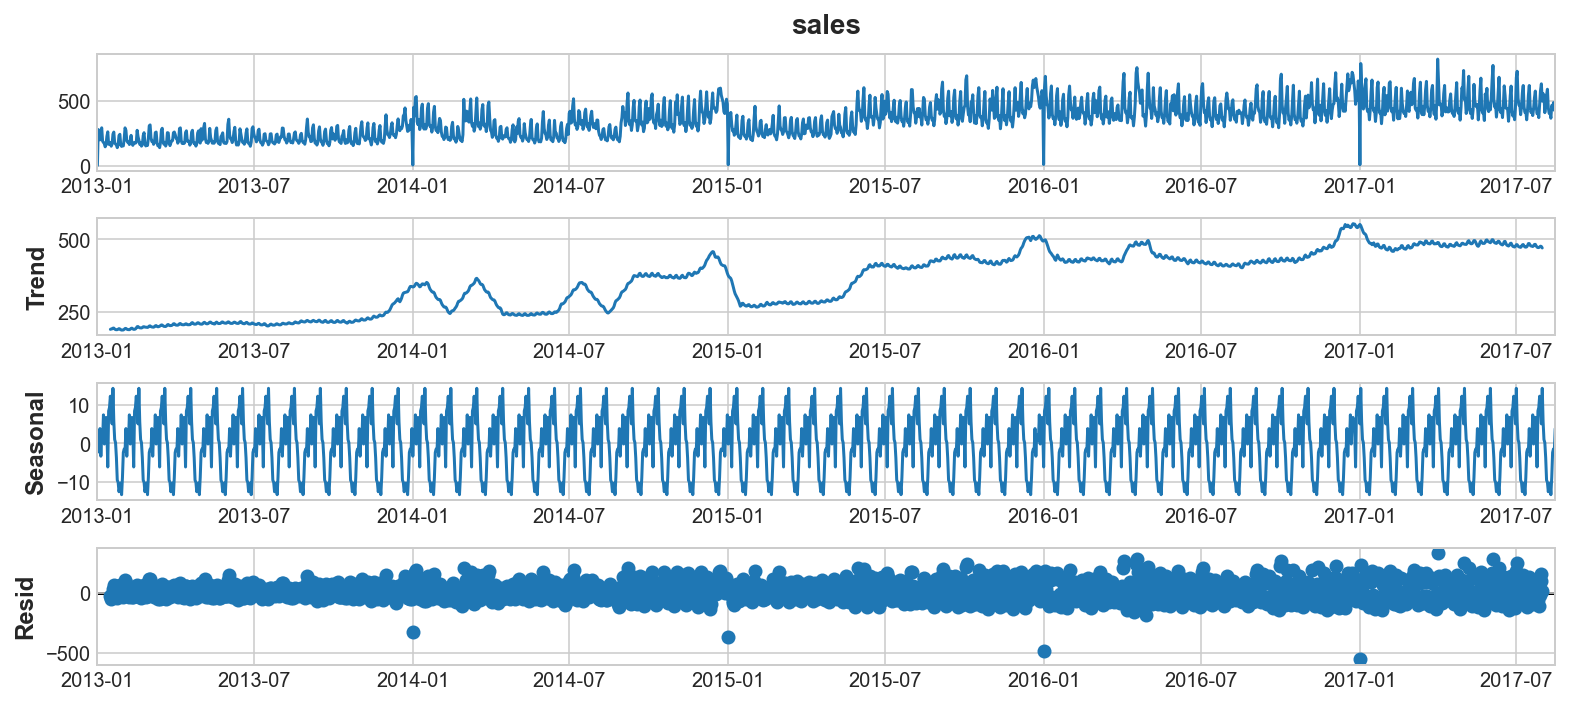

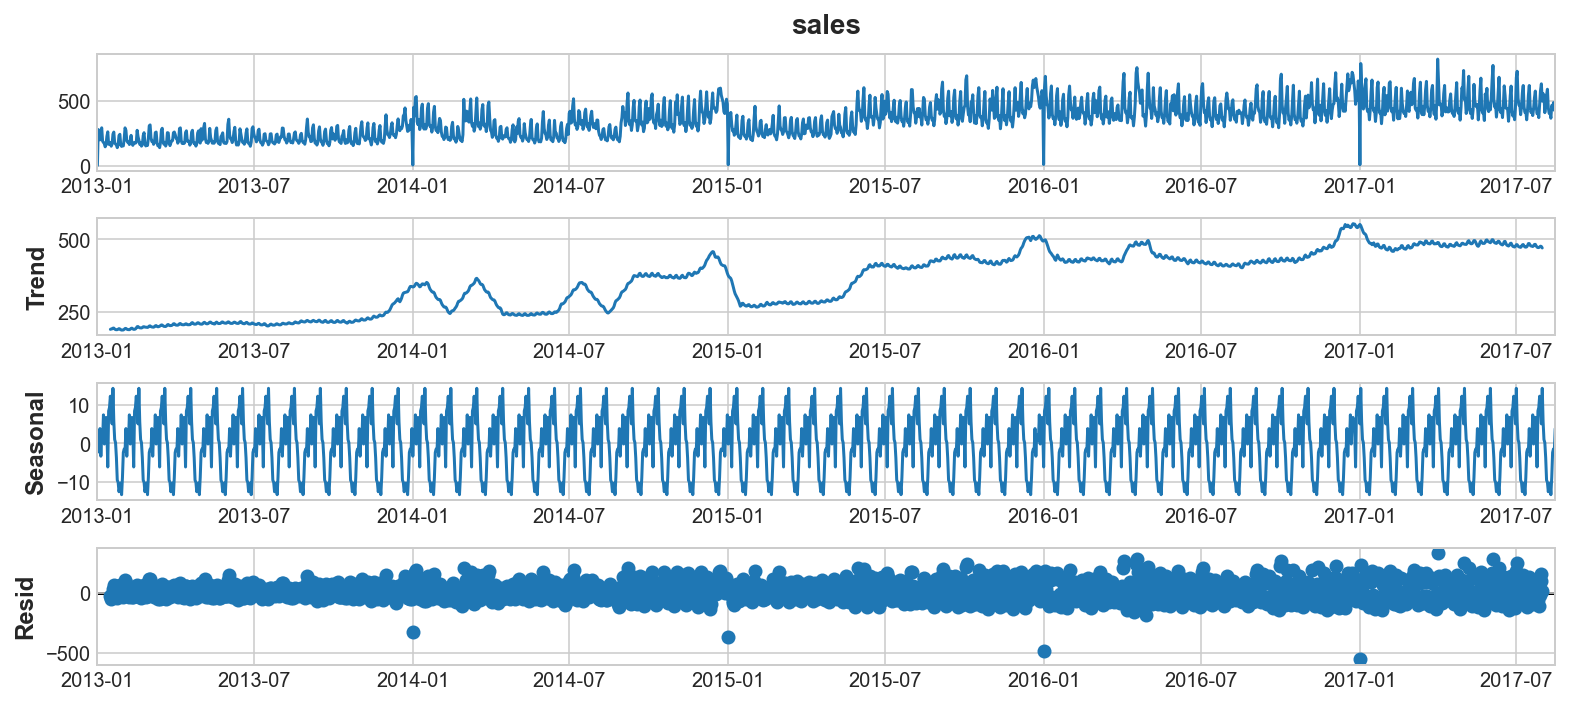

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decomp = seasonal_decompose(train_sales['sales'], model="additive", period=30)
seasonal_decomp.plot()
#detrended = df['Number of Passengers'].values - result_mul.trend
#plt.plot(detrended)

In [63]:
#train_sales.index = pd.to_datetime(train_sales.index, format = "%Y-%m-%d") 

In [72]:
#from pandas import date_range
#index = date_range(start="2013-1-1", end='2017-08-15', freq="D")
#index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')

In [73]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="Q", order=4)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

In [74]:
#X

const   trend  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
2013-01-01   1.00    1.00    0.00    0.00    0.00    0.00    0.00    0.00   
2013-01-02   1.00    2.00    1.00    0.00    0.00    0.00    0.00    0.00   
2013-01-03   1.00    3.00    0.00    1.00    0.00    0.00    0.00    0.00   
2013-01-04   1.00    4.00    0.00    0.00    1.00    0.00    0.00    0.00   
2013-01-05   1.00    5.00    0.00    0.00    0.00    1.00    0.00    0.00   
2013-01-06   1.00    6.00    0.00    0.00    0.00    0.00    1.00    0.00   
2013-01-07   1.00    7.00    0.00    0.00    0.00    0.00    0.00    1.00   
2013-01-08   1.00    8.00    0.00    0.00    0.00    0.00    0.00    0.00   
2013-01-09   1.00    9.00    1.00    0.00    0.00    0.00    0.00    0.00   
2013-01-10   1.00   10.00    0.00    1.00    0.00    0.00    0.00    0.00   
2013-01-11   1.00   11.00    0.00    0.00    1.00    0.00    0.00    0.00   
2013-01-12   1.00   12.00    0.00    0.00    0.00    1.00    0.00    0.00   
2013-01-13   1.00   13.00    0.00    0.00    0.00    0.00    1.00    0.00   
2013-01-14   1.00   14.00    0.00    0.00    0.00    0.00    0.00    1.00   
2013-01-15   1.00   15.00    0.00    0.00    0.00    0.00    0.00    0.00   
2013-01-16   1.00   16.00    1.00    0.00    0.00    0.00    0.00    0.00   
2013-01-17   1.00   17.00    0.00    1.00    0.00    0.00    0.00    0.00   
2013-01-18   1.00   18.00    0.00    0.00    1.00    0.00    0.00    0.00   
2013-01-19   1.00   19.00    0.00    0.00    0.00    1.00    0.00    0.00   
2013-01-20   1.00   20.00    0.00    0.00    0.00    0.00    1.00    0.00   
2013-01-21   1.00   21.00    0.00    0.00    0.00    0.00    0.00    1.00   
2013-01-22   1.00   22.00    0.00    0.00    0.00    0.00    0.00    0.00   
2013-01-23   1.00   23.00    1.00    0.00    0.00    0.00    0.00    0.00   
2013-01-24   1.00   24.00    0.00    1.00    0.00    0.00    0.00    0.00   
2013-01-25   1.00   25.00    0.00    0.00    1.00    0.00    0.00    0.00   
2013-01-26   1.00   26.00    0.00    0.00    0.00    1.00    0.00    0.00   
2013-01-27   1.00   27.00    0.00    0.00    0.00    0.00    1.00    0.00   
2013-01-28   1.00   28.00    0.00    0.00    0.00    0.00    0.00    1.00   
2013-01-29   1.00   29.00    0.00    0.00    0.00    0.00    0.00    0.00   
2013-01-30   1.00   30.00    1.00    0.00    0.00    0.00    0.00    0.00   
2013-01-31   1.00   31.00    0.00    1.00    0.00    0.00    0.00    0.00   
2013-02-01   1.00   32.00    0.00    0.00    1.00    0.00    0.00    0.00   
2013-02-02   1.00   33.00    0.00    0.00    0.00    1.00    0.00    0.00   
2013-02-03   1.00   34.00    0.00    0.00    0.00    0.00    1.00    0.00   
2013-02-04   1.00   35.00    0.00    0.00    0.00    0.00    0.00    1.00   
2013-02-05   1.00   36.00    0.00    0.00    0.00    0.00    0.00    0.00   
2013-02-06   1.00   37.00    1.00    0.00    0.00    0.00    0.00    0.00   
2013-02-07   1.00   38.00    0.00    1.00    0.00    0.00    0.00    0.00   
2013-02-08   1.00   39.00    0.00    0.00    1.00    0.00    0.00    0.00   
2013-02-09   1.00   40.00    0.00    0.00    0.00    1.00    0.00    0.00   
2013-02-10   1.00   41.00    0.00    0.00    0.00    0.00    1.00    0.00   
2013-02-11   1.00   42.00    0.00    0.00    0.00    0.00    0.00    1.00   
2013-02-12   1.00   43.00    0.00    0.00    0.00    0.00    0.00    0.00   
2013-02-13   1.00   44.00    1.00    0.00    0.00    0.00    0.00    0.00   
2013-02-14   1.00   45.00    0.00    1.00    0.00    0.00    0.00    0.00   
2013-02-15   1.00   46.00    0.00    0.00    1.00    0.00    0.00    0.00   
2013-02-16   1.00   47.00    0.00    0.00    0.00    1.00    0.00    0.00   
2013-02-17   1.00   48.00    0.00    0.00    0.00    0.00    1.00    0.00   
2013-02-18   1.00   49.00    0.00    0.00    0.00    0.00    0.00    1.00   
2013-02-19   1.00   50.00    0.00    0.00    0.00    0.00    0.00    0.00   
2013-02-20   1.00   51.00    1.00    0.00    0.00    0.00    0.00    0.00   
2013-02-

In [ ]:
# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)

## Training Data Correlations

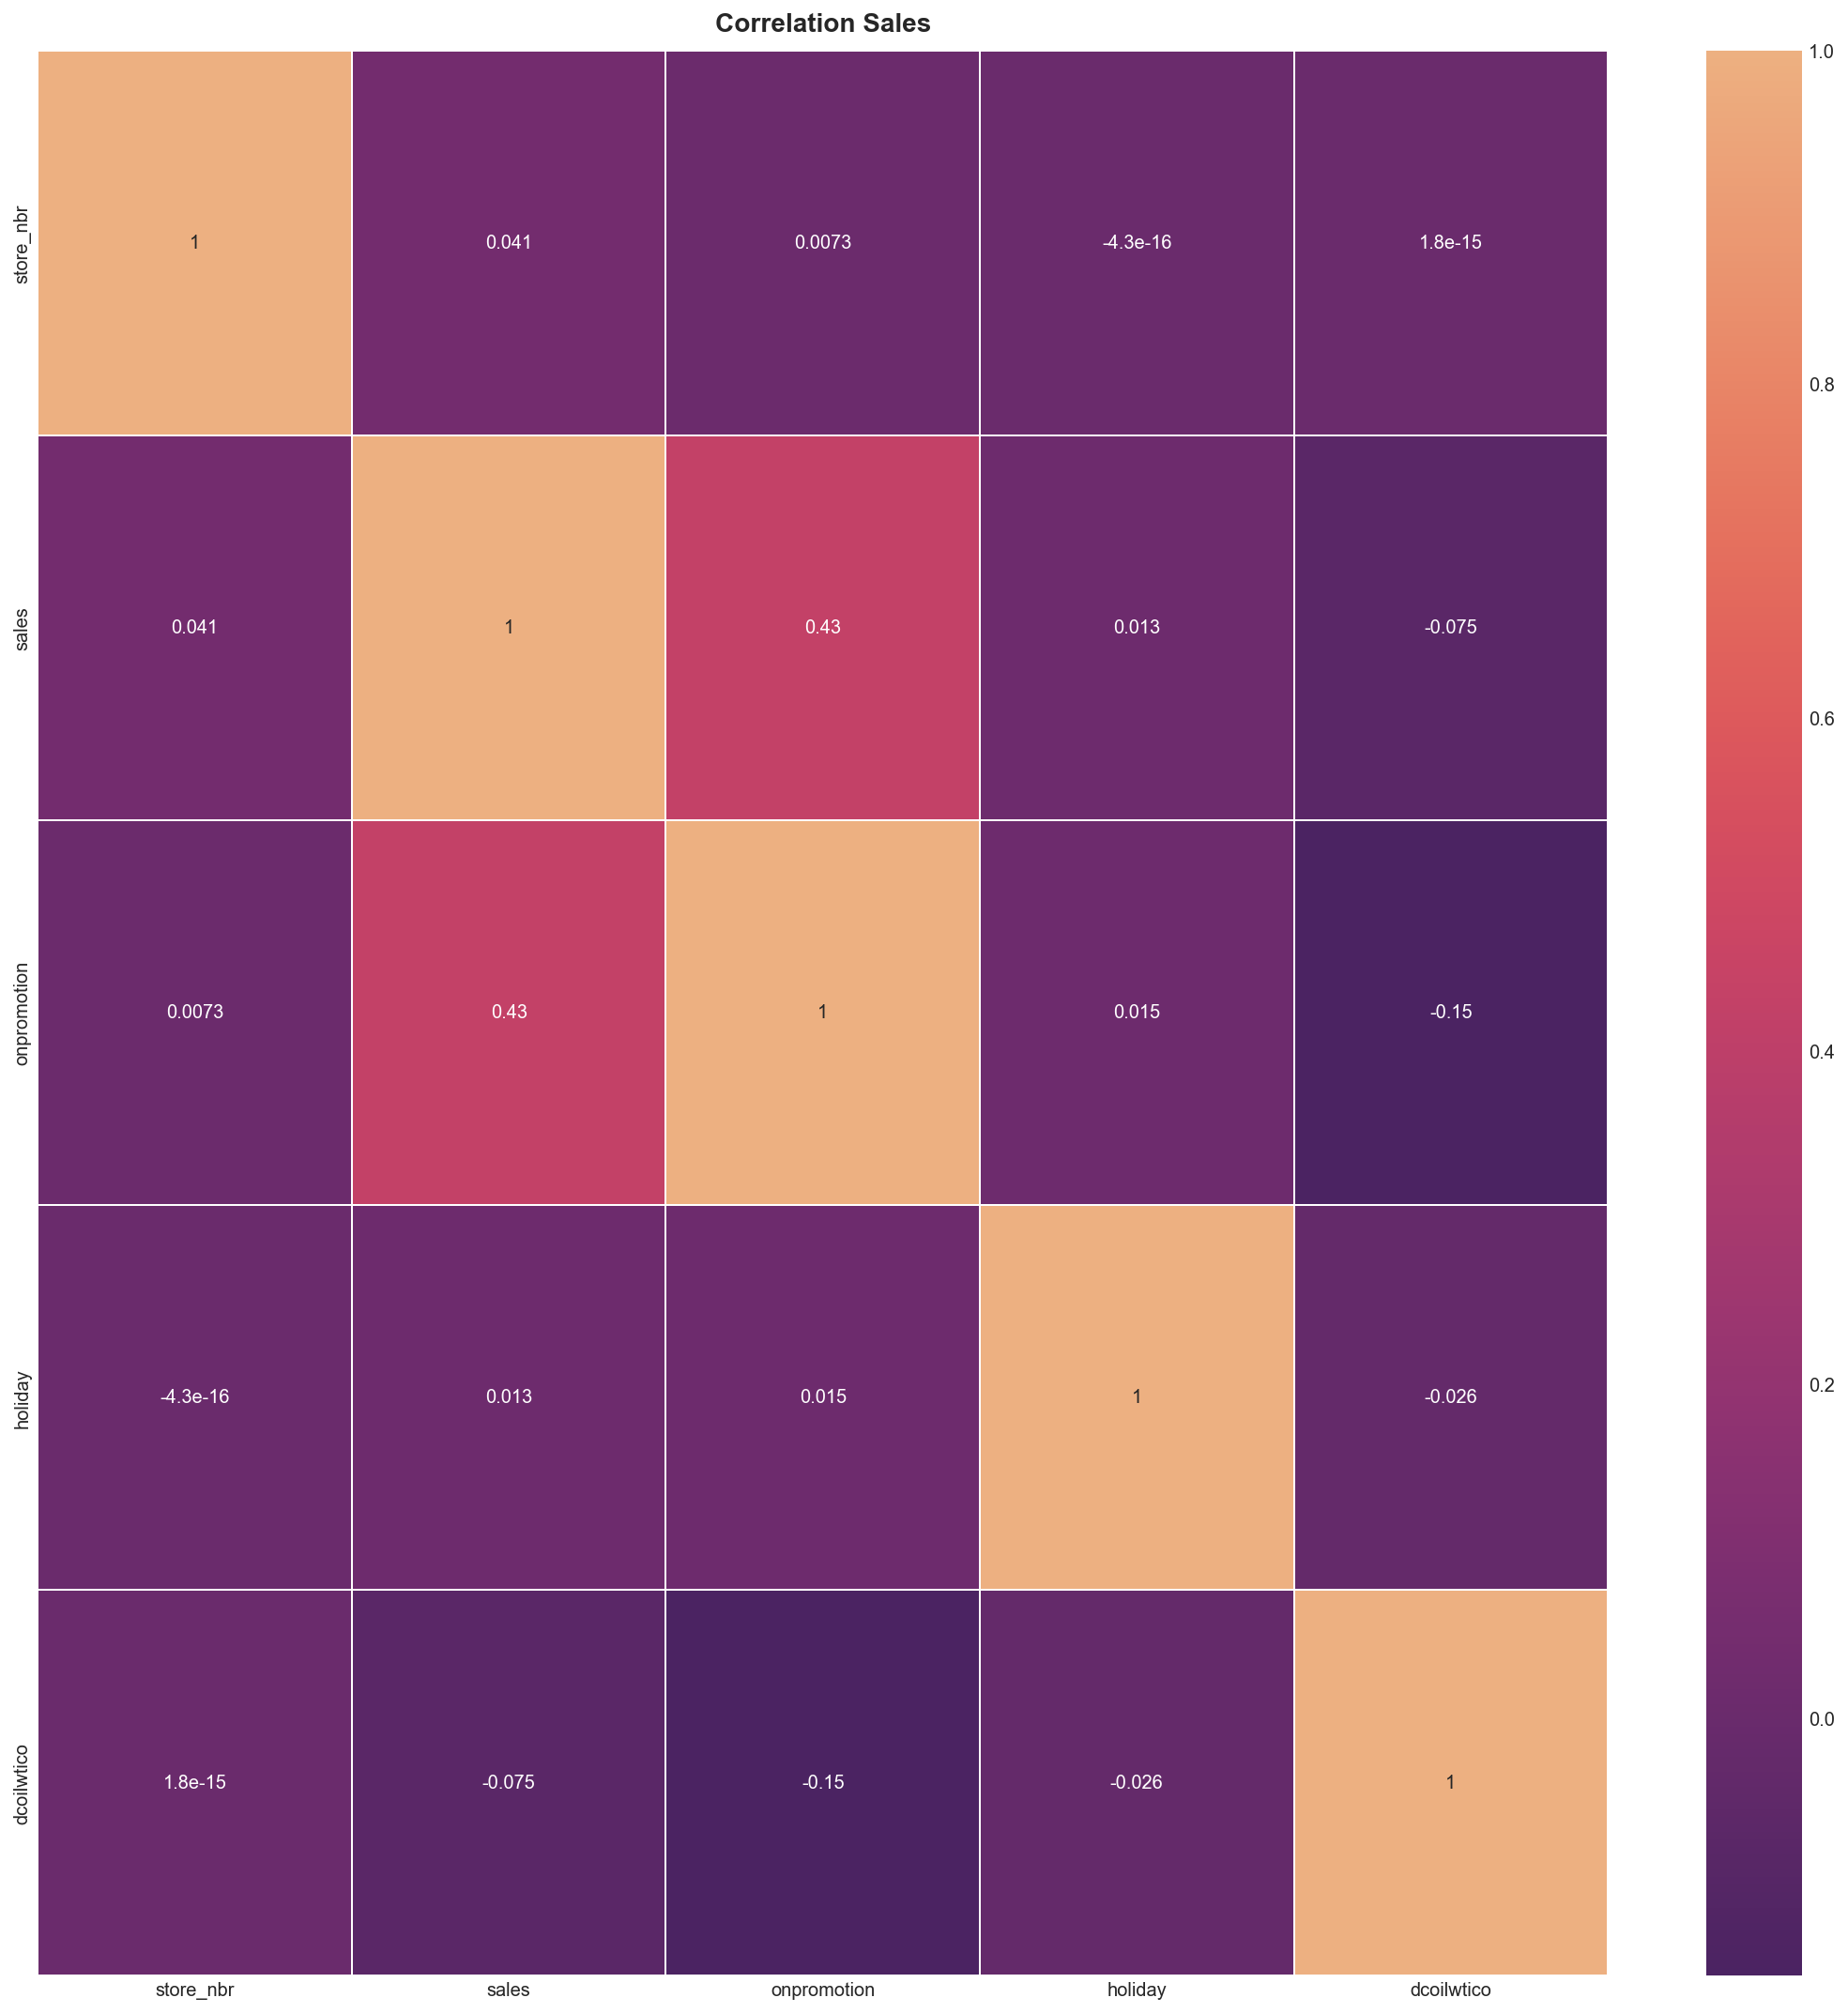

In [50]:
plt.figure(figsize=(15, 15))
sns.heatmap(train2.corr(), annot=True, cmap="flare_r", linewidths=0.1, annot_kws={"fontsize":10})
plt.title("Correlation Sales");

# Modeling

## Preprcessing

In [53]:
#full_data['year'] = full_data.date.dt.year
train3['month'] = train3.date.dt.month
#full_data['monthday'] = full_data.date.dt.day
train3['weekday'] = train3.date.dt.dayofweek

train = train3[train3.date <= "2016-08-01"] 
test = train3[train3.date > "2016-08-01"] 

In [54]:
train

date  store_nbr                      family   sales  \
0       2013-01-01          1                  AUTOMOTIVE    0.00   
1       2013-01-01          1                   BABY CARE    0.00   
2       2013-01-01          1                      BEAUTY    0.00   
3       2013-01-01          1                   BEVERAGES    0.00   
4       2013-01-01          1                       BOOKS    0.00   
...            ...        ...                         ...     ...   
2370055 2016-08-01          9                     POULTRY  680.39   
2370056 2016-08-01          9              PREPARED FOODS  117.02   
2370057 2016-08-01          9                     PRODUCE 1778.86   
2370058 2016-08-01          9  SCHOOL AND OFFICE SUPPLIES    7.00   
2370059 2016-08-01          9                     SEAFOOD   15.09   

         onpromotion  holiday  dcoilwtico    lag1    lag2    lag3   lag4  \
0                  0        1       93.14     NaN     NaN     NaN    NaN   
1                  0        1       93.14     NaN     NaN     NaN    NaN   
2                  0        1       93.14     NaN     NaN     NaN    NaN   
3                  0        1       93.14     NaN     NaN     NaN    NaN   
4                  0        1       93.14     NaN     NaN     NaN    NaN   
...              ...      ...         ...     ...     ...     ...    ...   
2370055            1        0       40.05  686.80  498.45  439.26 310.36   
2370056            1        0       40.05  119.44  144.53   91.01  69.33   
2370057            3        0       40.05 2252.29 1706.04 1219.33 840.24   
2370058            0        0       40.05    6.00    5.00    1.00   1.00   
2370059            1        0       40.05   48.56   32.56   12.96   9.00   

           lag5    lag6    lag7    lag8  month  weekday  
0           NaN     NaN     NaN     NaN      1        1  
1           NaN     NaN     NaN     NaN      1        1  
2           NaN     NaN     NaN     NaN      1        1  
3           NaN     NaN     NaN     NaN      1        1  
4           NaN     NaN     NaN     NaN      1        1  
...         ...     ...     ...     ...    ...      ...  
2370055  305.06  402.59  386.31  505.50      8        0  
2370056   99.99   62.38   80.82   88.80      8        0  
2370057 1038.26 2019.59 1313.18 1829.68      8        0  
2370058    5.00    1.00    4.00    4.00      8        0  
2370059    9.46   16.29   11.55   17.68      8        0  

[2327292 rows x 17 columns]

In [55]:
test

date  store_nbr                      family   sales  \
2370060 2016-08-02          1                  AUTOMOTIVE   10.00   
2370061 2016-08-02          1                   BABY CARE    0.00   
2370062 2016-08-02          1                      BEAUTY    0.00   
2370063 2016-08-02          1                   BEVERAGES 1859.00   
2370064 2016-08-02          1                       BOOKS    0.00   
...            ...        ...                         ...     ...   
3054343 2017-08-15          9                     POULTRY  438.13   
3054344 2017-08-15          9              PREPARED FOODS  154.55   
3054345 2017-08-15          9                     PRODUCE 2419.73   
3054346 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES  121.00   
3054347 2017-08-15          9                     SEAFOOD   16.00   

         onpromotion  holiday  dcoilwtico    lag1    lag2    lag3    lag4  \
2370060            0        0       39.50    3.00    3.00    9.00    8.00   
2370061            0        0       39.50    0.00    0.00    0.00    0.00   
2370062            0        0       39.50    3.00    1.00    4.00    1.00   
2370063           12        0       39.50 2418.00  858.00 2286.00 1671.00   
2370064            0        0       39.50    0.00    0.00    0.00    0.00   
...              ...      ...         ...     ...     ...     ...     ...   
3054343            0        1       47.57  283.43  412.46  383.39  525.22   
3054344            1        1       47.57  114.12  105.17  129.90  112.10   
3054345          148        1       47.57 1348.42 1693.61 1419.26 1453.08   
3054346            8        1       47.57  182.00  200.00  138.00  140.00   
3054347            0        1       47.57   17.00   20.00   16.86   23.83   

           lag5    lag6    lag7    lag8  month  weekday  
2370060    3.00    0.00    4.00    5.00      8        1  
2370061    0.00    0.00    0.00    0.00      8        1  
2370062    3.00    2.00    3.00    3.00      8        1  
2370063 1742.00 2166.00 1898.00 1929.00      8        1  
2370064    0.00    0.00    0.00    0.00      8        1  
...         ...     ...     ...     ...    ...      ...  
3054343  291.82  333.13  358.13  459.04      8        1  
3054344  111.93  123.47  112.95  119.90      8        1  
3054345 1036.44 1310.45 2299.72 1675.09      8        1  
3054346  148.00   83.00  170.00  146.00      8        1  
3054347   14.35   17.60   15.68   23.63      8        1  

[673596 rows x 17 columns]

In [21]:
#train.dropna(axis=0,subset = ['sales'], inplace = True) # droping null values from target.

X_train = train.drop(['date','sales'], axis =1)
y_train = train.sales

X_test = test.drop(['date','sales'], axis =1)
y_test = test.sales

In [22]:
# A categorical transformer.
cat_trans = Pipeline(steps = [
    ('imputer',SimpleImputer(strategy = 'most_frequent')),
    ('ohe',OneHotEncoder(handle_unknown = 'ignore'))
])

# A preprocessor that combines the two previous transformers.
preprocessor = ColumnTransformer(transformers = [
    ('cat', cat_trans, ['family'])
],
    remainder = "drop")

X_train_trans = preprocessor.fit_transform(X_train).toarray()
X_valid_trans = preprocessor.transform(X_valid).toarray()

## Training Model

In [23]:
LR_model = LinearRegression() # creating linear regression model.

LR_model.fit(X_train_trans, y_train) # fitting the model with the training data.
preds_LR = LR_model.predict(X_valid_trans) # predict the target.

mean_absolute_error(y_valid, preds_LR) # geting the mean absolute error for predictions.

240.39347467683726

# Now let's make our submission!

In [24]:
# preprocessing whole train and test data.
train_trans = preprocessor.fit_transform(X_train_full).toarray()
test_trans = preprocessor.transform(test.drop('sales',axis=1)).toarray()

In [25]:
LR_model = LinearRegression()

LR_model.fit(train_trans, y_train_full)
preds_LR = LR_model.predict(test_trans)

In [26]:
submission = pd.read_csv('../input/store-sales-time-series-forecasting/sample_submission.csv') # reading the sample_submission dataset.
submission['sales'] = preds_LR # assigning sales to our predictions.
submission

id   sales
0      3000888    5.89
1      3000889    0.11
2      3000890    3.55
3      3000891 2386.26
4      3000892    0.14
...        ...     ...
28507  3029395  350.71
28508  3029396   96.80
28509  3029397 1349.30
28510  3029398    3.34
28511  3029399   21.93

[28512 rows x 2 columns]

In [27]:
submission.to_csv('submission.csv', index=False, header=True) # submitting.

# All Done!